# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.optim.lr_scheduler import MultiStepLR

#Tracking experiments
%pip install -q wandb
import wandb
wandb.login()

Note: you may need to restart the kernel to use updated packages.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: niccolo-arati (dla-labs). Use `wandb login --relogin` to force relogin


True

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [2]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size = 784, output_size = 10, layers = [32, 32]):
        super().__init__()

        self.first_layer = nn.Linear(input_size, layers[0])
        self.inner_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.last_layer = nn.Linear(layers[-1], output_size)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.first_layer(x))
        for layer in self.inner_layers:
            x = F.relu(layer(x))
        x = F.relu(self.last_layer(x))
        return x

In [3]:
model = MultiLayerPerceptron(layers = [32, 32, 32])
model

MultiLayerPerceptron(
  (first_layer): Linear(in_features=784, out_features=32, bias=True)
  (inner_layers): ModuleList(
    (0-1): 2 x Linear(in_features=32, out_features=32, bias=True)
  )
  (last_layer): Linear(in_features=32, out_features=10, bias=True)
)

In [2]:
from tqdm import tqdm

#Trainig loop
def train(model, optimizer, dl_train, epoch, device = 'cuda'):
    model.train()
    #save losses of this epoch
    train_losses = []

    for (x_train, y_train) in tqdm(dl_train, desc=f'Training epoch {epoch}', leave=True):
        x_train, y_train = x_train.to(device), y_train.to(device)
        #Training step for current batch
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = F.cross_entropy(y_pred, y_train)

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    return (np.mean(train_losses))

In [3]:
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

#Validation
def evaluate(model, dl_val, val_size, classes, device = 'cuda', test = False):
    model.eval()
    val_corr = 0
    val_losses = []
    y_val_conf = []
    predicted_conf = []

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for data_val in dl_val:
            x_val, y_val = data_val
            y_val_conf.extend(y_val.detach().cpu().numpy()) #collect ground truths
            x_val, y_val = x_val.to(device), y_val.to(device)

            y_pred = model(x_val)
            loss_val = F.cross_entropy(y_pred, y_val)
            val_losses.append(loss_val.item())

            predicted = torch.max(y_pred.data, 1)[1]
            predicted_conf.extend(predicted.detach().cpu().numpy())
            val_corr += (predicted == y_val).sum().item()

    val_accuracy = val_corr / val_size
    if not test:
        print(f'Validation accuracy: {val_accuracy * 100}%')

    else:
        #Build confusion matrix
        cf_matrix = confusion_matrix(y_val_conf, predicted_conf)
        df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                            columns = [i for i in classes])
        plt.figure(figsize = (12,7))
        sn.heatmap(df_cm, annot=True)
        #plt.savefig('output.png')

    return np.mean(val_losses), val_accuracy

In [6]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

# Load MNIST train and test.
dataset_train = MNIST(root='./data', train=True, download=True, transform=transform) #60000 images
ds_test = MNIST(root='./data', train=False, download=True, transform=transform) #10000 images

classes = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine')

# Split train set into train and validation sets.
val_size = 5000
#set seed to always have the same training/validation sets
np.random.seed(111)
I = np.random.permutation(len(dataset_train)) # Order MNIST_train randomly.
ds_val = Subset(dataset_train, I[:val_size])  # Use torch Subset to sample a validation set.
ds_train = Subset(dataset_train, I[val_size:])  # The rest of original training set is train set.

Training epoch 0: 100%|██████████| 430/430 [00:07<00:00, 54.23it/s]


Validation accuracy: 88.52%


Training epoch 1: 100%|██████████| 430/430 [00:07<00:00, 59.18it/s]


Validation accuracy: 90.8%


Training epoch 2: 100%|██████████| 430/430 [00:07<00:00, 58.99it/s]


Validation accuracy: 91.53999999999999%


Training epoch 3: 100%|██████████| 430/430 [00:06<00:00, 64.16it/s]


Validation accuracy: 92.2%


Training epoch 4: 100%|██████████| 430/430 [00:06<00:00, 64.35it/s]


Validation accuracy: 92.64%


Training epoch 5: 100%|██████████| 430/430 [00:06<00:00, 64.51it/s]


Validation accuracy: 93.12%


Training epoch 6: 100%|██████████| 430/430 [00:07<00:00, 60.34it/s]


Validation accuracy: 93.7%


Training epoch 7: 100%|██████████| 430/430 [00:06<00:00, 65.00it/s]


Validation accuracy: 93.97999999999999%


Training epoch 8: 100%|██████████| 430/430 [00:06<00:00, 65.57it/s]


Validation accuracy: 94.17999999999999%


Training epoch 9: 100%|██████████| 430/430 [00:06<00:00, 65.82it/s]


Validation accuracy: 94.48%


Training epoch 10: 100%|██████████| 430/430 [00:06<00:00, 65.37it/s]


Validation accuracy: 94.66%


Training epoch 11: 100%|██████████| 430/430 [00:06<00:00, 65.39it/s]


Validation accuracy: 95.0%


Training epoch 12: 100%|██████████| 430/430 [00:06<00:00, 65.45it/s]


Validation accuracy: 95.06%


Training epoch 13: 100%|██████████| 430/430 [00:06<00:00, 65.82it/s]


Validation accuracy: 95.17999999999999%


Training epoch 14: 100%|██████████| 430/430 [00:07<00:00, 56.01it/s]


Validation accuracy: 95.3%


Training epoch 15: 100%|██████████| 430/430 [00:07<00:00, 59.00it/s]


Validation accuracy: 95.5%


Training epoch 16: 100%|██████████| 430/430 [00:07<00:00, 59.99it/s]


Validation accuracy: 95.64%


Training epoch 17: 100%|██████████| 430/430 [00:08<00:00, 50.22it/s]


Validation accuracy: 95.66%


Training epoch 18: 100%|██████████| 430/430 [00:06<00:00, 62.17it/s]


Validation accuracy: 95.8%


Training epoch 19: 100%|██████████| 430/430 [00:06<00:00, 63.96it/s]


Validation accuracy: 96.0%


Training epoch 20: 100%|██████████| 430/430 [00:08<00:00, 52.94it/s]


Validation accuracy: 95.92%


Training epoch 21: 100%|██████████| 430/430 [00:06<00:00, 62.54it/s]


Validation accuracy: 95.92%


Training epoch 22: 100%|██████████| 430/430 [00:06<00:00, 63.36it/s]


Validation accuracy: 95.94%


Training epoch 23: 100%|██████████| 430/430 [00:06<00:00, 62.02it/s]


Validation accuracy: 96.06%


Training epoch 24: 100%|██████████| 430/430 [00:06<00:00, 63.30it/s]


Validation accuracy: 96.04%


Training epoch 25: 100%|██████████| 430/430 [00:06<00:00, 63.35it/s]


Validation accuracy: 96.3%


Training epoch 26: 100%|██████████| 430/430 [00:07<00:00, 60.45it/s]


Validation accuracy: 96.2%


Training epoch 27: 100%|██████████| 430/430 [00:07<00:00, 61.07it/s]


Validation accuracy: 96.34%


Training epoch 28: 100%|██████████| 430/430 [00:06<00:00, 63.98it/s]


Validation accuracy: 96.22%


Training epoch 29: 100%|██████████| 430/430 [00:08<00:00, 48.28it/s]


Validation accuracy: 96.36%


Training epoch 30: 100%|██████████| 430/430 [00:06<00:00, 63.18it/s]


Validation accuracy: 96.3%


Training epoch 31: 100%|██████████| 430/430 [00:06<00:00, 63.48it/s]


Validation accuracy: 96.44%


Training epoch 32: 100%|██████████| 430/430 [00:06<00:00, 65.68it/s]


Validation accuracy: 96.58%


Training epoch 33: 100%|██████████| 430/430 [00:06<00:00, 62.96it/s]


Validation accuracy: 96.64%


Training epoch 34: 100%|██████████| 430/430 [00:06<00:00, 65.26it/s]


Validation accuracy: 96.67999999999999%


Training epoch 35: 100%|██████████| 430/430 [00:06<00:00, 64.47it/s]


Validation accuracy: 96.64%


Training epoch 36: 100%|██████████| 430/430 [00:07<00:00, 60.92it/s]


Validation accuracy: 96.58%


Training epoch 37: 100%|██████████| 430/430 [00:06<00:00, 67.63it/s]


Validation accuracy: 96.72%


Training epoch 38: 100%|██████████| 430/430 [00:07<00:00, 60.79it/s]


Validation accuracy: 96.74000000000001%


Training epoch 39: 100%|██████████| 430/430 [00:06<00:00, 67.44it/s]


Validation accuracy: 96.74000000000001%


Training epoch 40: 100%|██████████| 430/430 [00:07<00:00, 60.16it/s]


Validation accuracy: 97.04%


Training epoch 41: 100%|██████████| 430/430 [00:07<00:00, 59.96it/s]


Validation accuracy: 96.98%


Training epoch 42: 100%|██████████| 430/430 [00:07<00:00, 58.31it/s]


Validation accuracy: 96.94%


Training epoch 43: 100%|██████████| 430/430 [00:06<00:00, 64.13it/s]


Validation accuracy: 97.1%


Training epoch 44: 100%|██████████| 430/430 [00:07<00:00, 55.97it/s]


Validation accuracy: 96.98%


Training epoch 45: 100%|██████████| 430/430 [00:06<00:00, 65.65it/s]


Validation accuracy: 96.94%


Training epoch 46: 100%|██████████| 430/430 [00:07<00:00, 54.60it/s]


Validation accuracy: 97.0%


Training epoch 47: 100%|██████████| 430/430 [00:07<00:00, 54.97it/s]


Validation accuracy: 96.96000000000001%


Training epoch 48: 100%|██████████| 430/430 [00:06<00:00, 62.22it/s]


Validation accuracy: 97.14%


Training epoch 49: 100%|██████████| 430/430 [00:06<00:00, 62.51it/s]


Validation accuracy: 97.14%


Training epoch 50: 100%|██████████| 430/430 [00:07<00:00, 55.75it/s]


Validation accuracy: 97.04%


Training epoch 51: 100%|██████████| 430/430 [00:06<00:00, 65.23it/s]


Validation accuracy: 97.16%


Training epoch 52: 100%|██████████| 430/430 [00:06<00:00, 64.39it/s]


Validation accuracy: 97.2%


Training epoch 53: 100%|██████████| 430/430 [00:06<00:00, 64.51it/s]


Validation accuracy: 97.1%


Training epoch 54: 100%|██████████| 430/430 [00:06<00:00, 65.24it/s]


Validation accuracy: 97.14%


Training epoch 55: 100%|██████████| 430/430 [00:06<00:00, 66.80it/s]


Validation accuracy: 97.18%


Training epoch 56: 100%|██████████| 430/430 [00:06<00:00, 63.67it/s]


Validation accuracy: 97.24000000000001%


Training epoch 57: 100%|██████████| 430/430 [00:06<00:00, 61.68it/s]


Validation accuracy: 97.24000000000001%


Training epoch 58: 100%|██████████| 430/430 [00:08<00:00, 52.82it/s]


Validation accuracy: 97.24000000000001%


Training epoch 59: 100%|██████████| 430/430 [00:08<00:00, 51.92it/s]


Validation accuracy: 97.36%


Training epoch 60: 100%|██████████| 430/430 [00:07<00:00, 55.44it/s]


Validation accuracy: 97.26%


Training epoch 61: 100%|██████████| 430/430 [00:07<00:00, 61.38it/s]


Validation accuracy: 97.3%


Training epoch 62: 100%|██████████| 430/430 [00:06<00:00, 63.31it/s]


Validation accuracy: 97.22%


Training epoch 63: 100%|██████████| 430/430 [00:06<00:00, 63.73it/s]


Validation accuracy: 97.36%


Training epoch 64: 100%|██████████| 430/430 [00:06<00:00, 64.42it/s]


Validation accuracy: 97.26%


Training epoch 65: 100%|██████████| 430/430 [00:06<00:00, 64.41it/s]


Validation accuracy: 97.39999999999999%


Training epoch 66: 100%|██████████| 430/430 [00:07<00:00, 58.30it/s]


Validation accuracy: 97.39999999999999%


Training epoch 67: 100%|██████████| 430/430 [00:07<00:00, 60.14it/s]


Validation accuracy: 97.36%


Training epoch 68: 100%|██████████| 430/430 [00:06<00:00, 65.34it/s]


Validation accuracy: 97.22%


Training epoch 69: 100%|██████████| 430/430 [00:07<00:00, 54.86it/s]


Validation accuracy: 97.44%


Training epoch 70: 100%|██████████| 430/430 [00:06<00:00, 64.23it/s]


Validation accuracy: 97.38%


Training epoch 71: 100%|██████████| 430/430 [00:07<00:00, 56.53it/s]


Validation accuracy: 97.34%


Training epoch 72: 100%|██████████| 430/430 [00:06<00:00, 62.40it/s]


Validation accuracy: 97.32%


Training epoch 73: 100%|██████████| 430/430 [00:07<00:00, 59.99it/s]


Validation accuracy: 97.34%


Training epoch 74: 100%|██████████| 430/430 [00:06<00:00, 64.37it/s]


Validation accuracy: 97.54%


Training epoch 75: 100%|██████████| 430/430 [00:06<00:00, 63.99it/s]


Validation accuracy: 97.42%


Training epoch 76: 100%|██████████| 430/430 [00:06<00:00, 64.44it/s]


Validation accuracy: 97.36%


Training epoch 77: 100%|██████████| 430/430 [00:06<00:00, 64.29it/s]


Validation accuracy: 97.5%


Training epoch 78: 100%|██████████| 430/430 [00:07<00:00, 54.04it/s]


Validation accuracy: 97.46000000000001%


Training epoch 79: 100%|██████████| 430/430 [00:06<00:00, 64.71it/s]


Validation accuracy: 97.42%


Training epoch 80: 100%|██████████| 430/430 [00:07<00:00, 55.31it/s]


Validation accuracy: 97.39999999999999%


Training epoch 81: 100%|██████████| 430/430 [00:06<00:00, 61.77it/s]


Validation accuracy: 97.42%


Training epoch 82: 100%|██████████| 430/430 [00:06<00:00, 64.32it/s]


Validation accuracy: 97.44%


Training epoch 83: 100%|██████████| 430/430 [00:06<00:00, 64.59it/s]


Validation accuracy: 97.32%


Training epoch 84: 100%|██████████| 430/430 [00:07<00:00, 59.97it/s]


Validation accuracy: 97.58%


Training epoch 85: 100%|██████████| 430/430 [00:06<00:00, 61.89it/s]


Validation accuracy: 97.36%


Training epoch 86: 100%|██████████| 430/430 [00:06<00:00, 66.12it/s]


Validation accuracy: 97.39999999999999%


Training epoch 87: 100%|██████████| 430/430 [00:06<00:00, 66.90it/s]


Validation accuracy: 97.5%


Training epoch 88: 100%|██████████| 430/430 [00:06<00:00, 64.81it/s]


Validation accuracy: 97.46000000000001%


Training epoch 89: 100%|██████████| 430/430 [00:06<00:00, 64.72it/s]


Validation accuracy: 97.46000000000001%


Training epoch 90: 100%|██████████| 430/430 [00:06<00:00, 64.36it/s]


Validation accuracy: 97.44%


Training epoch 91: 100%|██████████| 430/430 [00:06<00:00, 64.43it/s]


Validation accuracy: 97.56%


Training epoch 92: 100%|██████████| 430/430 [00:07<00:00, 60.78it/s]


Validation accuracy: 97.52%


Training epoch 93: 100%|██████████| 430/430 [00:06<00:00, 66.16it/s]


Validation accuracy: 97.54%


Training epoch 94: 100%|██████████| 430/430 [00:06<00:00, 64.85it/s]


Validation accuracy: 97.5%


Training epoch 95: 100%|██████████| 430/430 [00:06<00:00, 65.03it/s]


Validation accuracy: 97.52%


Training epoch 96: 100%|██████████| 430/430 [00:06<00:00, 65.67it/s]


Validation accuracy: 97.48%


Training epoch 97: 100%|██████████| 430/430 [00:06<00:00, 63.73it/s]


Validation accuracy: 97.39999999999999%


Training epoch 98: 100%|██████████| 430/430 [00:07<00:00, 57.79it/s]


Validation accuracy: 97.44%


Training epoch 99: 100%|██████████| 430/430 [00:07<00:00, 58.78it/s]


Validation accuracy: 97.39999999999999%
Accuracy report on TEST: 97.46000000000001%


Test Accuracy,▁
Train Loss,█▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇████████████████████████
Validation Loss,█▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Accuracy,0.9746
Train Loss,0.01324
Validation Accuracy,0.974
Validation Loss,0.08511


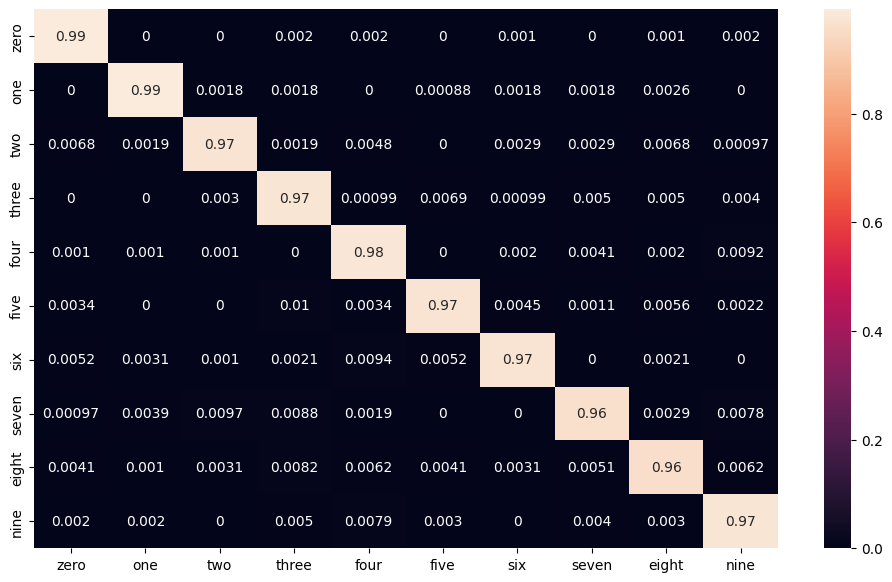

In [7]:
#track run, depth = 2
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"MLP depth 2",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "MLP",
    "dataset": "mnist",
    "epochs": 100,
    "batch_size": 128,
    "validation_set_size": 5000,
    "layers": [64]})

dl_train = torch.utils.data.DataLoader(ds_train, run.config["batch_size"], shuffle=True)
dl_val   = torch.utils.data.DataLoader(ds_val, run.config["batch_size"])
dl_test  = torch.utils.data.DataLoader(ds_test, run.config["batch_size"], shuffle=True)

#Training and Test
device = 'cuda'

modelMLP = MultiLayerPerceptron(layers = run.config["layers"]).to(device)
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=run.config["learning_rate"])

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelMLP, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    validation_loss, validation_accuracy = evaluate(modelMLP, dl_val, run.config["validation_set_size"], classes)
    if validation_accuracy >= best_accuracy:
        state_dict = modelMLP.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    wandb.log({**metrics, **val_metrics})

#Test
modelMLP.load_state_dict(state_dict)

_, test_accuracy = evaluate(modelMLP, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

Run aumentando la depth:

Training epoch 0: 100%|██████████| 430/430 [00:08<00:00, 50.04it/s]


Validation accuracy: 70.58%


Training epoch 1: 100%|██████████| 430/430 [00:07<00:00, 54.31it/s]


Validation accuracy: 73.24000000000001%


Training epoch 2: 100%|██████████| 430/430 [00:07<00:00, 61.05it/s]


Validation accuracy: 73.96000000000001%


Training epoch 3: 100%|██████████| 430/430 [00:07<00:00, 58.89it/s]


Validation accuracy: 74.5%


Training epoch 4: 100%|██████████| 430/430 [00:07<00:00, 56.42it/s]


Validation accuracy: 74.8%


Training epoch 5: 100%|██████████| 430/430 [00:06<00:00, 65.02it/s]


Validation accuracy: 75.12%


Training epoch 6: 100%|██████████| 430/430 [00:07<00:00, 56.85it/s]


Validation accuracy: 75.88000000000001%


Training epoch 7: 100%|██████████| 430/430 [00:07<00:00, 57.64it/s]


Validation accuracy: 75.68%


Training epoch 8: 100%|██████████| 430/430 [00:08<00:00, 51.18it/s]


Validation accuracy: 76.0%


Training epoch 9: 100%|██████████| 430/430 [00:07<00:00, 60.70it/s]


Validation accuracy: 76.22%


Training epoch 10: 100%|██████████| 430/430 [00:07<00:00, 58.95it/s]


Validation accuracy: 76.64%


Training epoch 11: 100%|██████████| 430/430 [00:07<00:00, 61.21it/s]


Validation accuracy: 76.74%


Training epoch 12: 100%|██████████| 430/430 [00:07<00:00, 60.87it/s]


Validation accuracy: 76.84%


Training epoch 13: 100%|██████████| 430/430 [00:07<00:00, 60.90it/s]


Validation accuracy: 76.98%


Training epoch 14: 100%|██████████| 430/430 [00:07<00:00, 61.15it/s]


Validation accuracy: 77.2%


Training epoch 15: 100%|██████████| 430/430 [00:07<00:00, 60.28it/s]


Validation accuracy: 77.24%


Training epoch 16: 100%|██████████| 430/430 [00:08<00:00, 52.64it/s]


Validation accuracy: 77.25999999999999%


Training epoch 17: 100%|██████████| 430/430 [00:07<00:00, 61.07it/s]


Validation accuracy: 77.2%


Training epoch 18: 100%|██████████| 430/430 [00:07<00:00, 59.19it/s]


Validation accuracy: 77.46%


Training epoch 19: 100%|██████████| 430/430 [00:07<00:00, 60.71it/s]


Validation accuracy: 77.38000000000001%


Training epoch 20: 100%|██████████| 430/430 [00:06<00:00, 62.69it/s]


Validation accuracy: 77.7%


Training epoch 21: 100%|██████████| 430/430 [00:07<00:00, 59.35it/s]


Validation accuracy: 77.42%


Training epoch 22: 100%|██████████| 430/430 [00:07<00:00, 61.16it/s]


Validation accuracy: 77.53999999999999%


Training epoch 23: 100%|██████████| 430/430 [00:07<00:00, 58.25it/s]


Validation accuracy: 77.66%


Training epoch 24: 100%|██████████| 430/430 [00:07<00:00, 60.76it/s]


Validation accuracy: 77.64%


Training epoch 25: 100%|██████████| 430/430 [00:06<00:00, 62.96it/s]


Validation accuracy: 77.64%


Training epoch 26: 100%|██████████| 430/430 [00:06<00:00, 65.19it/s]


Validation accuracy: 77.68%


Training epoch 27: 100%|██████████| 430/430 [00:06<00:00, 65.09it/s]


Validation accuracy: 77.72%


Training epoch 28: 100%|██████████| 430/430 [00:06<00:00, 62.08it/s]


Validation accuracy: 77.82%


Training epoch 29: 100%|██████████| 430/430 [00:06<00:00, 61.96it/s]


Validation accuracy: 77.74%


Training epoch 30: 100%|██████████| 430/430 [00:06<00:00, 61.66it/s]


Validation accuracy: 77.78%


Training epoch 31: 100%|██████████| 430/430 [00:06<00:00, 61.64it/s]


Validation accuracy: 77.88000000000001%


Training epoch 32: 100%|██████████| 430/430 [00:06<00:00, 61.43it/s]


Validation accuracy: 77.74%


Training epoch 33: 100%|██████████| 430/430 [00:06<00:00, 61.71it/s]


Validation accuracy: 78.0%


Training epoch 34: 100%|██████████| 430/430 [00:08<00:00, 53.10it/s]


Validation accuracy: 77.9%


Training epoch 35: 100%|██████████| 430/430 [00:06<00:00, 61.63it/s]


Validation accuracy: 77.82%


Training epoch 36: 100%|██████████| 430/430 [00:07<00:00, 60.59it/s]


Validation accuracy: 77.98%


Training epoch 37: 100%|██████████| 430/430 [00:07<00:00, 59.26it/s]


Validation accuracy: 77.75999999999999%


Training epoch 38: 100%|██████████| 430/430 [00:07<00:00, 56.21it/s]


Validation accuracy: 78.0%


Training epoch 39: 100%|██████████| 430/430 [00:07<00:00, 54.15it/s]


Validation accuracy: 78.02%


Training epoch 40: 100%|██████████| 430/430 [00:07<00:00, 60.74it/s]


Validation accuracy: 77.94%


Training epoch 41: 100%|██████████| 430/430 [00:07<00:00, 61.43it/s]


Validation accuracy: 78.03999999999999%


Training epoch 42: 100%|██████████| 430/430 [00:07<00:00, 59.33it/s]


Validation accuracy: 77.8%


Training epoch 43: 100%|██████████| 430/430 [00:07<00:00, 60.64it/s]


Validation accuracy: 77.96%


Training epoch 44: 100%|██████████| 430/430 [00:07<00:00, 59.51it/s]


Validation accuracy: 77.96%


Training epoch 45: 100%|██████████| 430/430 [00:07<00:00, 59.57it/s]


Validation accuracy: 78.0%


Training epoch 46: 100%|██████████| 430/430 [00:07<00:00, 55.15it/s]


Validation accuracy: 78.02%


Training epoch 47: 100%|██████████| 430/430 [00:07<00:00, 57.82it/s]


Validation accuracy: 77.92%


Training epoch 48: 100%|██████████| 430/430 [00:07<00:00, 57.93it/s]


Validation accuracy: 77.92%


Training epoch 49: 100%|██████████| 430/430 [00:07<00:00, 58.95it/s]


Validation accuracy: 77.86%


Training epoch 50: 100%|██████████| 430/430 [00:07<00:00, 60.27it/s]


Validation accuracy: 78.03999999999999%


Training epoch 51: 100%|██████████| 430/430 [00:08<00:00, 50.52it/s]


Validation accuracy: 77.9%


Training epoch 52: 100%|██████████| 430/430 [00:07<00:00, 61.36it/s]


Validation accuracy: 77.8%


Training epoch 53: 100%|██████████| 430/430 [00:08<00:00, 53.33it/s]


Validation accuracy: 77.75999999999999%


Training epoch 54: 100%|██████████| 430/430 [00:07<00:00, 61.29it/s]


Validation accuracy: 77.88000000000001%


Training epoch 55: 100%|██████████| 430/430 [00:07<00:00, 60.99it/s]


Validation accuracy: 77.82%


Training epoch 56: 100%|██████████| 430/430 [00:06<00:00, 61.66it/s]


Validation accuracy: 77.96%


Training epoch 57: 100%|██████████| 430/430 [00:08<00:00, 51.87it/s]


Validation accuracy: 77.8%


Training epoch 58: 100%|██████████| 430/430 [00:06<00:00, 65.52it/s]


Validation accuracy: 78.02%


Training epoch 59: 100%|██████████| 430/430 [00:07<00:00, 58.37it/s]


Validation accuracy: 77.82%


Training epoch 60: 100%|██████████| 430/430 [00:06<00:00, 61.98it/s]


Validation accuracy: 77.86%


Training epoch 61: 100%|██████████| 430/430 [00:07<00:00, 55.10it/s]


Validation accuracy: 77.78%


Training epoch 62: 100%|██████████| 430/430 [00:06<00:00, 65.51it/s]


Validation accuracy: 77.84%


Training epoch 63: 100%|██████████| 430/430 [00:06<00:00, 66.30it/s]


Validation accuracy: 77.7%


Training epoch 64: 100%|██████████| 430/430 [00:08<00:00, 51.75it/s]


Validation accuracy: 77.82%


Training epoch 65: 100%|██████████| 430/430 [00:07<00:00, 55.49it/s]


Validation accuracy: 77.74%


Training epoch 66: 100%|██████████| 430/430 [00:07<00:00, 58.21it/s]


Validation accuracy: 77.75999999999999%


Training epoch 67: 100%|██████████| 430/430 [00:06<00:00, 64.77it/s]


Validation accuracy: 77.78%


Training epoch 68: 100%|██████████| 430/430 [00:06<00:00, 61.91it/s]


Validation accuracy: 77.72%


Training epoch 69: 100%|██████████| 430/430 [00:06<00:00, 61.70it/s]


Validation accuracy: 77.64%


Training epoch 70: 100%|██████████| 430/430 [00:06<00:00, 61.64it/s]


Validation accuracy: 77.66%


Training epoch 71: 100%|██████████| 430/430 [00:06<00:00, 61.54it/s]


Validation accuracy: 77.9%


Training epoch 72: 100%|██████████| 430/430 [00:07<00:00, 61.34it/s]


Validation accuracy: 77.64%


Training epoch 73: 100%|██████████| 430/430 [00:06<00:00, 61.68it/s]


Validation accuracy: 77.75999999999999%


Training epoch 74: 100%|██████████| 430/430 [00:06<00:00, 63.85it/s]


Validation accuracy: 77.82%


Training epoch 75: 100%|██████████| 430/430 [00:06<00:00, 64.63it/s]


Validation accuracy: 77.84%


Training epoch 76: 100%|██████████| 430/430 [00:06<00:00, 63.92it/s]


Validation accuracy: 77.82%


Training epoch 77: 100%|██████████| 430/430 [00:07<00:00, 59.94it/s]


Validation accuracy: 77.84%


Training epoch 78: 100%|██████████| 430/430 [00:07<00:00, 61.20it/s]


Validation accuracy: 77.86%


Training epoch 79: 100%|██████████| 430/430 [00:07<00:00, 61.33it/s]


Validation accuracy: 77.68%


Training epoch 80: 100%|██████████| 430/430 [00:07<00:00, 58.65it/s]


Validation accuracy: 77.8%


Training epoch 81: 100%|██████████| 430/430 [00:06<00:00, 63.72it/s]


Validation accuracy: 77.78%


Training epoch 82: 100%|██████████| 430/430 [00:07<00:00, 60.50it/s]


Validation accuracy: 77.42%


Training epoch 83: 100%|██████████| 430/430 [00:07<00:00, 57.51it/s]


Validation accuracy: 77.66%


Training epoch 84: 100%|██████████| 430/430 [00:07<00:00, 55.43it/s]


Validation accuracy: 77.74%


Training epoch 85: 100%|██████████| 430/430 [00:07<00:00, 58.92it/s]


Validation accuracy: 77.82%


Training epoch 86: 100%|██████████| 430/430 [00:08<00:00, 50.39it/s]


Validation accuracy: 77.78%


Training epoch 87: 100%|██████████| 430/430 [00:07<00:00, 59.94it/s]


Validation accuracy: 77.88000000000001%


Training epoch 88: 100%|██████████| 430/430 [00:07<00:00, 59.05it/s]


Validation accuracy: 77.84%


Training epoch 89: 100%|██████████| 430/430 [00:07<00:00, 57.99it/s]


Validation accuracy: 77.86%


Training epoch 90: 100%|██████████| 430/430 [00:08<00:00, 49.62it/s]


Validation accuracy: 77.68%


Training epoch 91: 100%|██████████| 430/430 [00:07<00:00, 58.30it/s]


Validation accuracy: 77.86%


Training epoch 92: 100%|██████████| 430/430 [00:07<00:00, 60.65it/s]


Validation accuracy: 77.75999999999999%


Training epoch 93: 100%|██████████| 430/430 [00:07<00:00, 61.27it/s]


Validation accuracy: 77.74%


Training epoch 94: 100%|██████████| 430/430 [00:07<00:00, 61.27it/s]


Validation accuracy: 77.60000000000001%


Training epoch 95: 100%|██████████| 430/430 [00:07<00:00, 54.73it/s]


Validation accuracy: 77.78%


Training epoch 96: 100%|██████████| 430/430 [00:07<00:00, 57.55it/s]


Validation accuracy: 77.72%


Training epoch 97: 100%|██████████| 430/430 [00:07<00:00, 59.31it/s]


Validation accuracy: 77.62%


Training epoch 98: 100%|██████████| 430/430 [00:06<00:00, 62.31it/s]


Validation accuracy: 77.74%


Training epoch 99: 100%|██████████| 430/430 [00:07<00:00, 56.03it/s]


Validation accuracy: 77.74%
Accuracy report on TEST: 78.34%


Test Accuracy,▁
Train Loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▇▇▇▇████████████████████████████████
Validation Loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Test Accuracy,0.7834
Train Loss,0.46012
Validation Accuracy,0.7774
Validation Loss,0.62137


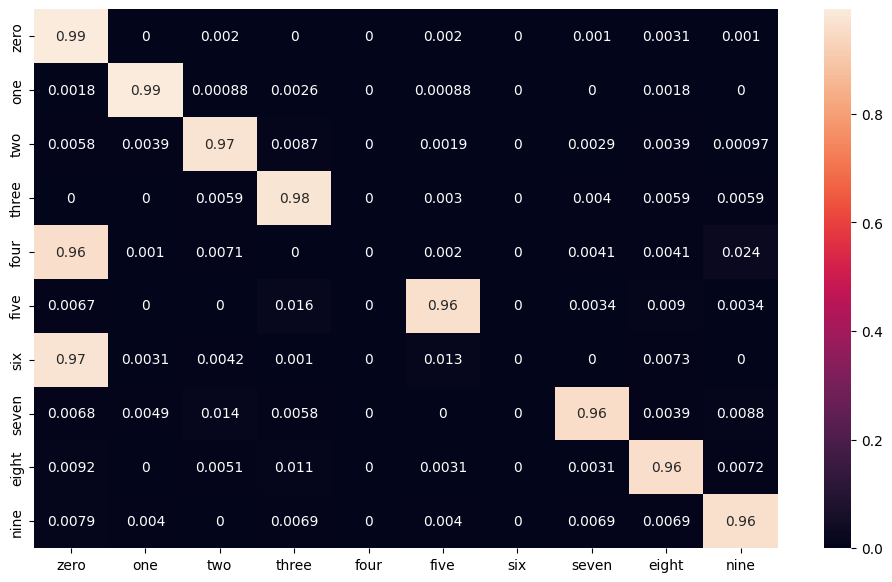

In [8]:
#track run, depth = 5
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"MLP depth 5",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "MLP",
    "dataset": "mnist",
    "epochs": 100,
    "batch_size": 128,
    "validation_set_size": 5000,
    "layers": [64, 64, 64, 64]})

dl_train = torch.utils.data.DataLoader(ds_train, run.config["batch_size"], shuffle=True)
dl_val   = torch.utils.data.DataLoader(ds_val, run.config["batch_size"])
dl_test  = torch.utils.data.DataLoader(ds_test, run.config["batch_size"], shuffle=True)

#Training and Test
device = 'cuda'

modelMLP = MultiLayerPerceptron(layers = run.config["layers"]).to(device)
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=run.config["learning_rate"])

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelMLP, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    (validation_loss, validation_accuracy) = evaluate(modelMLP, dl_val, run.config["validation_set_size"], classes)
    if validation_accuracy >= best_accuracy:
        state_dict = modelMLP.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    wandb.log({**metrics, **val_metrics})

#Test
modelMLP.load_state_dict(state_dict)

_, test_accuracy = evaluate(modelMLP, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

Training epoch 0: 100%|██████████| 430/430 [00:07<00:00, 55.32it/s]


Validation accuracy: 66.16%


Training epoch 1: 100%|██████████| 430/430 [00:07<00:00, 59.92it/s]


Validation accuracy: 71.38%


Training epoch 2: 100%|██████████| 430/430 [00:07<00:00, 58.60it/s]


Validation accuracy: 72.46000000000001%


Training epoch 3: 100%|██████████| 430/430 [00:07<00:00, 56.94it/s]


Validation accuracy: 73.52%


Training epoch 4: 100%|██████████| 430/430 [00:07<00:00, 59.02it/s]


Validation accuracy: 74.33999999999999%


Training epoch 5: 100%|██████████| 430/430 [00:08<00:00, 49.72it/s]


Validation accuracy: 74.7%


Training epoch 6: 100%|██████████| 430/430 [00:07<00:00, 58.55it/s]


Validation accuracy: 74.96000000000001%


Training epoch 7: 100%|██████████| 430/430 [00:07<00:00, 59.36it/s]


Validation accuracy: 75.26%


Training epoch 8: 100%|██████████| 430/430 [00:06<00:00, 61.54it/s]


Validation accuracy: 75.46000000000001%


Training epoch 9: 100%|██████████| 430/430 [00:07<00:00, 60.30it/s]


Validation accuracy: 75.66000000000001%


Training epoch 10: 100%|██████████| 430/430 [00:07<00:00, 58.86it/s]


Validation accuracy: 75.7%


Training epoch 11: 100%|██████████| 430/430 [00:07<00:00, 59.45it/s]


Validation accuracy: 75.86%


Training epoch 12: 100%|██████████| 430/430 [00:07<00:00, 58.35it/s]


Validation accuracy: 76.03999999999999%


Training epoch 13: 100%|██████████| 430/430 [00:07<00:00, 59.71it/s]


Validation accuracy: 76.32%


Training epoch 14: 100%|██████████| 430/430 [00:08<00:00, 50.28it/s]


Validation accuracy: 76.4%


Training epoch 15: 100%|██████████| 430/430 [00:08<00:00, 50.34it/s]


Validation accuracy: 76.32%


Training epoch 16: 100%|██████████| 430/430 [00:06<00:00, 61.88it/s]


Validation accuracy: 76.32%


Training epoch 17: 100%|██████████| 430/430 [00:07<00:00, 55.29it/s]


Validation accuracy: 76.48%


Training epoch 18: 100%|██████████| 430/430 [00:08<00:00, 48.79it/s]


Validation accuracy: 76.14%


Training epoch 19: 100%|██████████| 430/430 [00:07<00:00, 58.56it/s]


Validation accuracy: 76.48%


Training epoch 20: 100%|██████████| 430/430 [00:08<00:00, 53.28it/s]


Validation accuracy: 76.74%


Training epoch 21: 100%|██████████| 430/430 [00:07<00:00, 53.93it/s]


Validation accuracy: 76.66%


Training epoch 22: 100%|██████████| 430/430 [00:07<00:00, 58.05it/s]


Validation accuracy: 76.74%


Training epoch 23: 100%|██████████| 430/430 [00:07<00:00, 55.55it/s]


Validation accuracy: 76.66%


Training epoch 24: 100%|██████████| 430/430 [00:08<00:00, 51.61it/s]


Validation accuracy: 76.62%


Training epoch 25: 100%|██████████| 430/430 [00:07<00:00, 56.33it/s]


Validation accuracy: 76.7%


Training epoch 26: 100%|██████████| 430/430 [00:08<00:00, 48.90it/s]


Validation accuracy: 76.9%


Training epoch 27: 100%|██████████| 430/430 [00:08<00:00, 51.99it/s]


Validation accuracy: 76.8%


Training epoch 28: 100%|██████████| 430/430 [00:07<00:00, 56.98it/s]


Validation accuracy: 76.72%


Training epoch 29: 100%|██████████| 430/430 [00:07<00:00, 57.52it/s]


Validation accuracy: 76.82%


Training epoch 30: 100%|██████████| 430/430 [00:07<00:00, 58.51it/s]


Validation accuracy: 76.74%


Training epoch 31: 100%|██████████| 430/430 [00:07<00:00, 58.41it/s]


Validation accuracy: 77.0%


Training epoch 32: 100%|██████████| 430/430 [00:08<00:00, 51.20it/s]


Validation accuracy: 76.86%


Training epoch 33: 100%|██████████| 430/430 [00:08<00:00, 52.36it/s]


Validation accuracy: 77.0%


Training epoch 34: 100%|██████████| 430/430 [00:07<00:00, 58.61it/s]


Validation accuracy: 77.06%


Training epoch 35: 100%|██████████| 430/430 [00:07<00:00, 59.28it/s]


Validation accuracy: 76.84%


Training epoch 36: 100%|██████████| 430/430 [00:08<00:00, 53.08it/s]


Validation accuracy: 76.88000000000001%


Training epoch 37: 100%|██████████| 430/430 [00:07<00:00, 58.50it/s]


Validation accuracy: 76.98%


Training epoch 38: 100%|██████████| 430/430 [00:08<00:00, 48.16it/s]


Validation accuracy: 76.86%


Training epoch 39: 100%|██████████| 430/430 [00:07<00:00, 54.31it/s]


Validation accuracy: 76.92%


Training epoch 40: 100%|██████████| 430/430 [00:07<00:00, 58.45it/s]


Validation accuracy: 76.78%


Training epoch 41: 100%|██████████| 430/430 [00:07<00:00, 58.93it/s]


Validation accuracy: 76.86%


Training epoch 42: 100%|██████████| 430/430 [00:07<00:00, 56.80it/s]


Validation accuracy: 77.03999999999999%


Training epoch 43: 100%|██████████| 430/430 [00:07<00:00, 59.42it/s]


Validation accuracy: 76.92%


Training epoch 44: 100%|██████████| 430/430 [00:07<00:00, 54.31it/s]


Validation accuracy: 76.88000000000001%


Training epoch 45: 100%|██████████| 430/430 [00:07<00:00, 59.62it/s]


Validation accuracy: 76.98%


Training epoch 46: 100%|██████████| 430/430 [00:07<00:00, 59.23it/s]


Validation accuracy: 76.88000000000001%


Training epoch 47: 100%|██████████| 430/430 [00:07<00:00, 55.96it/s]


Validation accuracy: 77.02%


Training epoch 48: 100%|██████████| 430/430 [00:07<00:00, 55.31it/s]


Validation accuracy: 76.92%


Training epoch 49: 100%|██████████| 430/430 [00:07<00:00, 56.23it/s]


Validation accuracy: 76.62%


Training epoch 50: 100%|██████████| 430/430 [00:07<00:00, 56.09it/s]


Validation accuracy: 76.94%


Training epoch 51: 100%|██████████| 430/430 [00:07<00:00, 54.38it/s]


Validation accuracy: 76.92%


Training epoch 52: 100%|██████████| 430/430 [00:07<00:00, 56.40it/s]


Validation accuracy: 76.92%


Training epoch 53: 100%|██████████| 430/430 [00:08<00:00, 49.74it/s]


Validation accuracy: 77.02%


Training epoch 54: 100%|██████████| 430/430 [00:07<00:00, 58.52it/s]


Validation accuracy: 76.86%


Training epoch 55: 100%|██████████| 430/430 [00:07<00:00, 57.36it/s]


Validation accuracy: 76.96%


Training epoch 56: 100%|██████████| 430/430 [00:07<00:00, 56.86it/s]


Validation accuracy: 76.66%


Training epoch 57: 100%|██████████| 430/430 [00:07<00:00, 56.98it/s]


Validation accuracy: 76.8%


Training epoch 58: 100%|██████████| 430/430 [00:07<00:00, 58.53it/s]


Validation accuracy: 76.8%


Training epoch 59: 100%|██████████| 430/430 [00:07<00:00, 56.00it/s]


Validation accuracy: 76.68%


Training epoch 60: 100%|██████████| 430/430 [00:07<00:00, 58.57it/s]


Validation accuracy: 76.88000000000001%


Training epoch 61: 100%|██████████| 430/430 [00:07<00:00, 57.33it/s]


Validation accuracy: 76.74%


Training epoch 62: 100%|██████████| 430/430 [00:07<00:00, 55.88it/s]


Validation accuracy: 76.82%


Training epoch 63: 100%|██████████| 430/430 [00:08<00:00, 50.50it/s]


Validation accuracy: 76.66%


Training epoch 64: 100%|██████████| 430/430 [00:07<00:00, 54.82it/s]


Validation accuracy: 76.68%


Training epoch 65: 100%|██████████| 430/430 [00:07<00:00, 56.02it/s]


Validation accuracy: 76.6%


Training epoch 66: 100%|██████████| 430/430 [00:07<00:00, 59.16it/s]


Validation accuracy: 76.94%


Training epoch 67: 100%|██████████| 430/430 [00:07<00:00, 58.87it/s]


Validation accuracy: 76.92%


Training epoch 68: 100%|██████████| 430/430 [00:07<00:00, 54.51it/s]


Validation accuracy: 76.98%


Training epoch 69: 100%|██████████| 430/430 [00:07<00:00, 58.86it/s]


Validation accuracy: 76.9%


Training epoch 70: 100%|██████████| 430/430 [00:07<00:00, 57.00it/s]


Validation accuracy: 76.68%


Training epoch 71: 100%|██████████| 430/430 [00:07<00:00, 56.27it/s]


Validation accuracy: 76.58%


Training epoch 72: 100%|██████████| 430/430 [00:07<00:00, 58.05it/s]


Validation accuracy: 76.92%


Training epoch 73: 100%|██████████| 430/430 [00:07<00:00, 59.02it/s]


Validation accuracy: 76.9%


Training epoch 74: 100%|██████████| 430/430 [00:07<00:00, 58.86it/s]


Validation accuracy: 76.84%


Training epoch 75: 100%|██████████| 430/430 [00:07<00:00, 59.34it/s]


Validation accuracy: 76.82%


Training epoch 76: 100%|██████████| 430/430 [00:07<00:00, 57.82it/s]


Validation accuracy: 77.03999999999999%


Training epoch 77: 100%|██████████| 430/430 [00:08<00:00, 51.94it/s]


Validation accuracy: 77.0%


Training epoch 78: 100%|██████████| 430/430 [00:07<00:00, 57.38it/s]


Validation accuracy: 76.8%


Training epoch 79: 100%|██████████| 430/430 [00:08<00:00, 51.86it/s]


Validation accuracy: 76.92%


Training epoch 80: 100%|██████████| 430/430 [00:07<00:00, 59.31it/s]


Validation accuracy: 76.58%


Training epoch 81: 100%|██████████| 430/430 [00:08<00:00, 51.57it/s]


Validation accuracy: 76.96%


Training epoch 82: 100%|██████████| 430/430 [00:07<00:00, 54.93it/s]


Validation accuracy: 76.88000000000001%


Training epoch 83: 100%|██████████| 430/430 [00:07<00:00, 59.40it/s]


Validation accuracy: 76.02%


Training epoch 84: 100%|██████████| 430/430 [00:08<00:00, 51.55it/s]


Validation accuracy: 76.75999999999999%


Training epoch 85: 100%|██████████| 430/430 [00:07<00:00, 58.88it/s]


Validation accuracy: 76.75999999999999%


Training epoch 86: 100%|██████████| 430/430 [00:07<00:00, 59.49it/s]


Validation accuracy: 76.92%


Training epoch 87: 100%|██████████| 430/430 [00:07<00:00, 58.77it/s]


Validation accuracy: 76.78%


Training epoch 88: 100%|██████████| 430/430 [00:08<00:00, 52.51it/s]


Validation accuracy: 76.62%


Training epoch 89: 100%|██████████| 430/430 [00:07<00:00, 56.26it/s]


Validation accuracy: 76.66%


Training epoch 90: 100%|██████████| 430/430 [00:07<00:00, 54.66it/s]


Validation accuracy: 76.78%


Training epoch 91: 100%|██████████| 430/430 [00:07<00:00, 57.75it/s]


Validation accuracy: 76.68%


Training epoch 92: 100%|██████████| 430/430 [00:07<00:00, 56.59it/s]


Validation accuracy: 76.92%


Training epoch 93: 100%|██████████| 430/430 [00:07<00:00, 55.99it/s]


Validation accuracy: 77.0%


Training epoch 94: 100%|██████████| 430/430 [00:08<00:00, 51.24it/s]


Validation accuracy: 76.92%


Training epoch 95: 100%|██████████| 430/430 [00:07<00:00, 58.83it/s]


Validation accuracy: 76.9%


Training epoch 96: 100%|██████████| 430/430 [00:07<00:00, 58.65it/s]


Validation accuracy: 76.53999999999999%


Training epoch 97: 100%|██████████| 430/430 [00:07<00:00, 58.34it/s]


Validation accuracy: 77.0%


Training epoch 98: 100%|██████████| 430/430 [00:06<00:00, 61.70it/s]


Validation accuracy: 76.82%


Training epoch 99: 100%|██████████| 430/430 [00:07<00:00, 58.51it/s]


Validation accuracy: 77.03999999999999%
Accuracy report on TEST: 77.33%


Test Accuracy,▁
Train Loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▅▆▇▇▇███████████████████████████▇██████
Validation Loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Test Accuracy,0.7733
Train Loss,0.47767
Validation Accuracy,0.7704
Validation Loss,0.64713


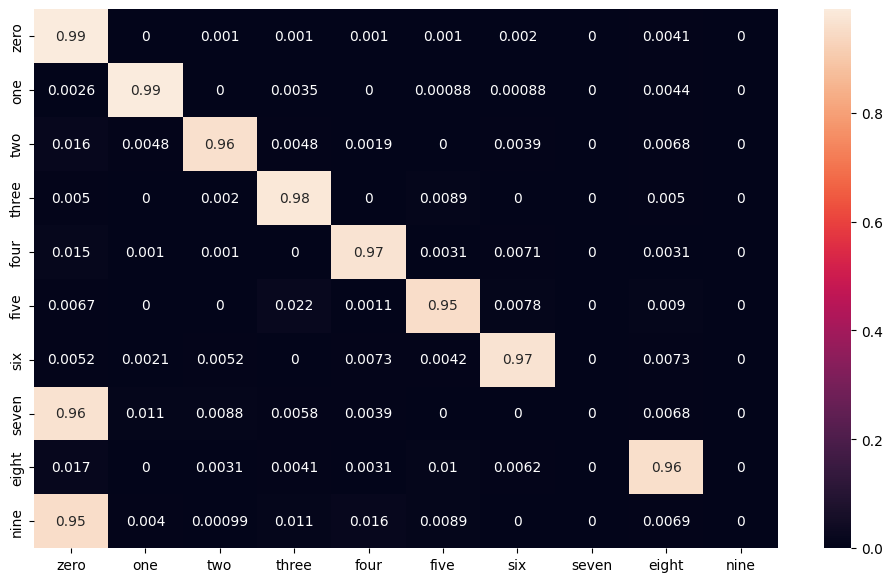

In [9]:
#track run, depth = 7
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"MLP depth 7",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "MLP",
    "dataset": "mnist",
    "epochs": 100,
    "batch_size": 128,
    "validation_set_size": 5000,
    "layers": [64, 64, 64, 64, 64, 64]})

dl_train = torch.utils.data.DataLoader(ds_train, run.config["batch_size"], shuffle=True)
dl_val   = torch.utils.data.DataLoader(ds_val, run.config["batch_size"])
dl_test  = torch.utils.data.DataLoader(ds_test, run.config["batch_size"], shuffle=True)

#Training and Test
device = 'cuda'

modelMLP = MultiLayerPerceptron(layers = run.config["layers"]).to(device)
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=run.config["learning_rate"])

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelMLP, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    (validation_loss, validation_accuracy) = evaluate(modelMLP, dl_val, run.config["validation_set_size"], classes)
    if validation_accuracy >= best_accuracy:
        state_dict = modelMLP.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    wandb.log({**metrics, **val_metrics})

#Test
modelMLP.load_state_dict(state_dict)

(_, test_accuracy) = evaluate(modelMLP, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 2.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [4]:
#load CIFAR-10
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees = 10, scale = (0.8, 1.2)),
     transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
     transforms.RandomCrop(28),
     transforms.Resize((32, 32)),
     transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
ds_test = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Split train set into train and validation sets.
val_size = 5000
#set seed to always have the same training/validation sets
np.random.seed(111)
I = np.random.permutation(len(trainset))
ds_val = Subset(trainset, I[:val_size])
ds_train = Subset(trainset, I[val_size:])

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, size = 3, stride = 1, downsample = None, padding = 1, residual=False):
        super().__init__()
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=size, stride=stride, padding=padding, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=size, padding=padding, bias=False)
        self.residual = residual
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.conv1(x))

        x = self.conv2(x)

        if self.residual:
            if self.downsample is not None:
                identity = self.downsample(identity)
            x += identity
        x = self.relu(x)

        return x

#layers: numero di blocchi per ogni layer
class CNN(nn.Module):
    def __init__(self, layers, num_classes = 10, residual=False):
        super().__init__()

        self.residual = residual
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)

        self.layer1 = self.make_layer(64, layers[0])
        self.layer2 = self.make_layer(128, layers[1], stride=2)
        self.layer3 = self.make_layer(256, layers[2], stride=2)
        #self.layer4 = self.make_layer(512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
                m.weight.data.normal_(0, 0.01)

    def make_layer(self, planes, blocks, stride = 1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Conv2d(self.inplanes, planes, kernel_size = 1, stride = stride, bias = False)

        layers = []
        layers.append(BasicBlock(self.inplanes, planes, stride=stride, downsample=downsample, residual=self.residual))
        self.inplanes = planes
        for _ in range(blocks - 1):
            layers.append(BasicBlock(self.inplanes, planes, residual=self.residual))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
#Check model
x = torch.randn(size=(1, 3, 28, 28))
x = x.to('cuda')
model_ex = CNN(layers = [1, 3, 2]).to('cuda')

print(model_ex)

print(model_ex.conv1(x).size())
print(model_ex.maxpool(model_ex.conv1(x)).size())
print(model_ex.layer1(model_ex.maxpool(model_ex.conv1(x))).size())
print(model_ex.layer2(model_ex.layer1(model_ex.maxpool(model_ex.conv1(x)))).size())
print(model_ex.layer3(model_ex.layer2(model_ex.layer1(model_ex.maxpool(model_ex.conv1(x))))).size())
print(model_ex.avgpool(model_ex.layer3(model_ex.layer2(model_ex.layer1(model_ex.maxpool(model_ex.conv1(x)))))).size())

Runs with CNN without residual connection

Training epoch 0: 100%|██████████| 176/176 [00:42<00:00,  4.15it/s]


Validation accuracy: 27.24%


Training epoch 1: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Validation accuracy: 36.42%


Training epoch 2: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Validation accuracy: 41.44%


Training epoch 3: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Validation accuracy: 43.54%


Training epoch 4: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 45.18%


Training epoch 5: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Validation accuracy: 48.96%


Training epoch 6: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Validation accuracy: 52.26%


Training epoch 7: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Validation accuracy: 50.63999999999999%


Training epoch 8: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Validation accuracy: 54.67999999999999%


Training epoch 9: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Validation accuracy: 54.74%


Training epoch 10: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Validation accuracy: 56.779999999999994%


Training epoch 11: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 58.879999999999995%


Training epoch 12: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 58.540000000000006%


Training epoch 13: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 58.919999999999995%


Training epoch 14: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 59.18%


Training epoch 15: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 60.419999999999995%


Training epoch 16: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 61.019999999999996%


Training epoch 17: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 62.28%


Training epoch 18: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 62.519999999999996%


Training epoch 19: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 63.32%


Training epoch 20: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 63.2%


Training epoch 21: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 63.44%


Training epoch 22: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Validation accuracy: 65.08%


Training epoch 23: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 65.02%


Training epoch 24: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 65.98%


Training epoch 25: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 66.32000000000001%


Training epoch 26: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 67.34%


Training epoch 27: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 66.60000000000001%


Training epoch 28: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Validation accuracy: 66.72%


Training epoch 29: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 68.5%


Training epoch 30: 100%|██████████| 176/176 [00:40<00:00,  4.37it/s]


Validation accuracy: 66.42%


Training epoch 31: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Validation accuracy: 67.56%


Training epoch 32: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 69.32000000000001%


Training epoch 33: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 67.44%


Training epoch 34: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 68.46%


Training epoch 35: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 68.02%


Training epoch 36: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 68.97999999999999%


Training epoch 37: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 69.19999999999999%


Training epoch 38: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 70.22%


Training epoch 39: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 69.52000000000001%


Training epoch 40: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 69.74000000000001%


Training epoch 41: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 68.24%


Training epoch 42: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 70.32000000000001%


Training epoch 43: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Validation accuracy: 70.7%


Training epoch 44: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 70.16%


Training epoch 45: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 70.86%


Training epoch 46: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 70.98%


Training epoch 47: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 70.04%


Training epoch 48: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 68.78%


Training epoch 49: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 70.36%


Training epoch 50: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 71.36%


Training epoch 51: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Validation accuracy: 71.02000000000001%


Training epoch 52: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 71.48%


Training epoch 53: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Validation accuracy: 72.06%


Training epoch 54: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 69.8%


Training epoch 55: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 71.5%


Training epoch 56: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 71.61999999999999%


Training epoch 57: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 72.36%


Training epoch 58: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 71.08%


Training epoch 59: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 71.78%


Training epoch 60: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 71.6%


Training epoch 61: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 71.7%


Training epoch 62: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 72.1%


Training epoch 63: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 71.14%


Training epoch 64: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 71.22%


Training epoch 65: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 71.78%


Training epoch 66: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 71.86%


Training epoch 67: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 72.34%


Training epoch 68: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 72.48%


Training epoch 69: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 71.34%


Training epoch 70: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 72.1%


Training epoch 71: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 72.18%


Training epoch 72: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 72.44%


Training epoch 73: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 72.8%


Training epoch 74: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 73.0%


Training epoch 75: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 72.96000000000001%


Training epoch 76: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 72.61999999999999%


Training epoch 77: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 72.74000000000001%


Training epoch 78: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 73.14%


Training epoch 79: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 72.06%


Training epoch 80: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 73.82%


Training epoch 81: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 73.94%


Training epoch 82: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 74.08%


Training epoch 83: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 74.94%


Training epoch 84: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 74.36%


Training epoch 85: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Validation accuracy: 75.0%


Training epoch 86: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 74.64%


Training epoch 87: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 74.3%


Training epoch 88: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 74.76%


Training epoch 89: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 75.12%


Training epoch 90: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 74.48%


Training epoch 91: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 75.3%


Training epoch 92: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Validation accuracy: 74.06%


Training epoch 93: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 74.64%


Training epoch 94: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 75.72%


Training epoch 95: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Validation accuracy: 74.68%


Training epoch 96: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Validation accuracy: 74.6%


Training epoch 97: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Validation accuracy: 75.06%


Training epoch 98: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Validation accuracy: 74.18%


Training epoch 99: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Validation accuracy: 75.0%
Accuracy report on TEST: 76.84%


Test Accuracy,▁
Train Loss,█▆▅▅▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇█████████████
Validation Loss,█▆▅▅▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Accuracy,0.7684
Train Loss,0.38331
Validation Accuracy,0.75
Validation Loss,0.80863


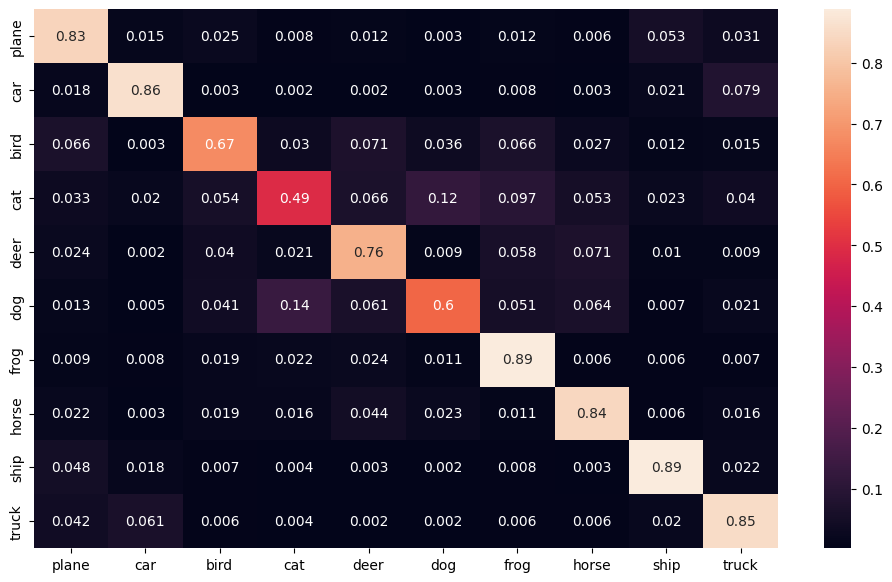

In [7]:
#track run, depth = 8
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"CNN depth 8",
    # Track hyperparameters and run metadata
    config={
    "initial_learning_rate": 0.001,
    "architecture": "CNN",
    "dataset": "Cifar10",
    "epochs": 100,
    "batch_size": 256,
    "validation_set_size": 5000,
    "layers": [1, 1, 1]})

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=run.config["batch_size"], shuffle=True)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size=run.config["batch_size"])
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=run.config["batch_size"], shuffle=False)

#Training and Test
device = 'cuda'

modelCNN = CNN(layers=run.config["layers"]).to(device)
optimizer = torch.optim.Adam(params=modelCNN.parameters(), lr=run.config["initial_learning_rate"])
scheduler = MultiStepLR(optimizer, milestones=[80, 160], gamma=0.1)

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelCNN, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    validation_loss, validation_accuracy = evaluate(modelCNN, dl_val, run.config["validation_set_size"], classes)
    if validation_accuracy >= best_accuracy:
        state_dict = modelCNN.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    scheduler.step()

    wandb.log({**metrics, **val_metrics})

#Test
modelCNN.load_state_dict(state_dict)

#save model on weights and biases
model_artifact = wandb.Artifact(
    "CNN_8", type="model",
    description="best model for CNN with depth 8",
    metadata=dict(run.config))

torch.save(modelCNN.state_dict(), "best_model_cnn.pth")
model_artifact.add_file("best_model_cnn.pth")
wandb.save("best_model_cnn.pth")
run.log_artifact(model_artifact)

_, test_accuracy = evaluate(modelCNN, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

Training epoch 0: 100%|██████████| 176/176 [00:42<00:00,  4.14it/s]


Validation accuracy: 9.8%


Training epoch 1: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 9.8%


Training epoch 2: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 9.74%


Training epoch 3: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 20.18%


Training epoch 4: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 22.74%


Training epoch 5: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 24.82%


Training epoch 6: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Validation accuracy: 26.700000000000003%


Training epoch 7: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 29.48%


Training epoch 8: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 32.04%


Training epoch 9: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 34.02%


Training epoch 10: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 34.760000000000005%


Training epoch 11: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 36.720000000000006%


Training epoch 12: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 36.64%


Training epoch 13: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Validation accuracy: 38.96%


Training epoch 14: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 39.44%


Training epoch 15: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 40.36%


Training epoch 16: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 40.0%


Training epoch 17: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 42.26%


Training epoch 18: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 41.959999999999994%


Training epoch 19: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 43.120000000000005%


Training epoch 20: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 43.480000000000004%


Training epoch 21: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 44.4%


Training epoch 22: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 43.88%


Training epoch 23: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 45.519999999999996%


Training epoch 24: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 46.02%


Training epoch 25: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 46.06%


Training epoch 26: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 46.46%


Training epoch 27: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 48.0%


Training epoch 28: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 47.74%


Training epoch 29: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 48.92%


Training epoch 30: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 48.1%


Training epoch 31: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 48.94%


Training epoch 32: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 49.8%


Training epoch 33: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 48.38%


Training epoch 34: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 49.980000000000004%


Training epoch 35: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 51.18000000000001%


Training epoch 36: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 50.660000000000004%


Training epoch 37: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 52.6%


Training epoch 38: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 53.879999999999995%


Training epoch 39: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 52.980000000000004%


Training epoch 40: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 53.0%


Training epoch 41: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 53.32%


Training epoch 42: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 53.239999999999995%


Training epoch 43: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 54.22%


Training epoch 44: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 53.66%


Training epoch 45: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 54.76%


Training epoch 46: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 55.00000000000001%


Training epoch 47: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 56.279999999999994%


Training epoch 48: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 55.60000000000001%


Training epoch 49: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 56.620000000000005%


Training epoch 50: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 56.06%


Training epoch 51: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 57.92%


Training epoch 52: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Validation accuracy: 57.199999999999996%


Training epoch 53: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 57.440000000000005%


Training epoch 54: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 58.699999999999996%


Training epoch 55: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 56.52%


Training epoch 56: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 58.84%


Training epoch 57: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 58.81999999999999%


Training epoch 58: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 59.31999999999999%


Training epoch 59: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 59.56%


Training epoch 60: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 59.9%


Training epoch 61: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 60.28%


Training epoch 62: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 60.64000000000001%


Training epoch 63: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 60.5%


Training epoch 64: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 60.96%


Training epoch 65: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 61.18%


Training epoch 66: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 60.699999999999996%


Training epoch 67: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Validation accuracy: 62.019999999999996%


Training epoch 68: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Validation accuracy: 62.28%


Training epoch 69: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 61.419999999999995%


Training epoch 70: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 61.8%


Training epoch 71: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 62.019999999999996%


Training epoch 72: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 63.18%


Training epoch 73: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 61.06%


Training epoch 74: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 62.68%


Training epoch 75: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 63.2%


Training epoch 76: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 63.5%


Training epoch 77: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 63.54%


Training epoch 78: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 64.66%


Training epoch 79: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 64.18%


Training epoch 80: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 66.44%


Training epoch 81: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 65.64%


Training epoch 82: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 65.94%


Training epoch 83: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 66.03999999999999%


Training epoch 84: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 65.84%


Training epoch 85: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 66.66%


Training epoch 86: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 65.75999999999999%


Training epoch 87: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Validation accuracy: 66.58%


Training epoch 88: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 67.4%


Training epoch 89: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 66.52%


Training epoch 90: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 66.62%


Training epoch 91: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 66.75999999999999%


Training epoch 92: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Validation accuracy: 65.88000000000001%


Training epoch 93: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 66.72%


Training epoch 94: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Validation accuracy: 68.06%


Training epoch 95: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 67.16%


Training epoch 96: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 67.10000000000001%


Training epoch 97: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 67.62%


Training epoch 98: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 66.92%


Training epoch 99: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Validation accuracy: 67.22%
Accuracy report on TEST: 68.4%


Test Accuracy,▁
Train Loss,▅█▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▁▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████
Validation Loss,██▆▆▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Test Accuracy,0.684
Train Loss,0.86738
Validation Accuracy,0.6722
Validation Loss,0.93607


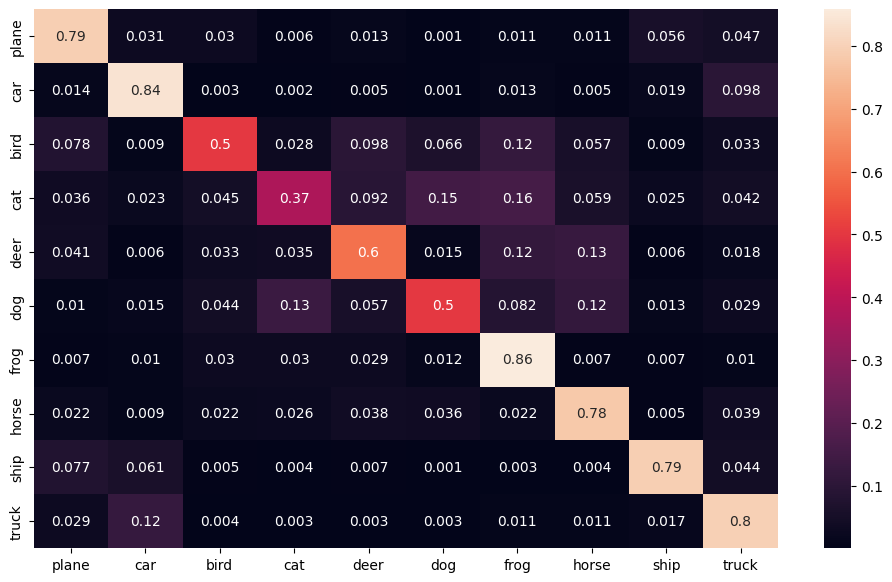

In [8]:
#track run, depth = 14
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"CNN depth 14",
    # Track hyperparameters and run metadata
    config={
    "initial_learning_rate": 0.001,
    "architecture": "CNN",
    "dataset": "Cifar10",
    "epochs": 100,
    "batch_size": 256,
    "validation_set_size": 5000,
    "layers": [2, 2, 2]})

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=run.config["batch_size"], shuffle=True)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size=run.config["batch_size"])
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=run.config["batch_size"], shuffle=False)

#Training and Test
device = 'cuda'

modelCNN = CNN(layers=run.config["layers"]).to(device)
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=run.config["initial_learning_rate"])
scheduler = MultiStepLR(optimizer, milestones=[80, 160], gamma=0.1)

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelCNN, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    validation_loss, validation_accuracy = evaluate(modelCNN, dl_val, run.config["validation_set_size"], classes)
    if validation_accuracy >= best_accuracy:
        state_dict = modelCNN.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    scheduler.step()

    wandb.log({**metrics, **val_metrics})

#Test
modelCNN.load_state_dict(state_dict)

#save model on weights and biases
model_artifact = wandb.Artifact(
    "CNN_14", type="model",
    description="best model for CNN with depth 14",
    metadata=dict(run.config))

torch.save(modelCNN.state_dict(), "best_model_cnn.pth")
model_artifact.add_file("best_model_cnn.pth")
wandb.save("best_model_cnn.pth")
run.log_artifact(model_artifact)

_, test_accuracy = evaluate(modelCNN, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

Training epoch 0: 100%|██████████| 176/176 [00:42<00:00,  4.16it/s]


Validation accuracy: 9.34%


Training epoch 1: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Validation accuracy: 9.34%


Training epoch 2: 100%|██████████| 176/176 [00:40<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 3: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Validation accuracy: 9.34%


Training epoch 4: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Validation accuracy: 9.34%


Training epoch 5: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Validation accuracy: 9.1%


Training epoch 6: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 7: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 8: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 9: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 10: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.34%


Training epoch 11: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 12: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 13: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 14: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 15: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 16: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 17: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 18: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.34%


Training epoch 19: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Validation accuracy: 9.1%


Training epoch 20: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Validation accuracy: 9.1%


Training epoch 21: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.34%


Training epoch 22: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.34%


Training epoch 23: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Validation accuracy: 9.1%


Training epoch 24: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Validation accuracy: 9.1%


Training epoch 25: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.34%


Training epoch 26: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.8%


Training epoch 27: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 28: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 29: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.8%


Training epoch 30: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 31: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.34%


Training epoch 32: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.34%


Training epoch 33: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.34%


Training epoch 34: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.34%


Training epoch 35: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.34%


Training epoch 36: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 37: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 38: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 39: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Validation accuracy: 9.1%


Training epoch 40: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.34%


Training epoch 41: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 42: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 43: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 44: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 45: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Validation accuracy: 9.8%


Training epoch 46: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Validation accuracy: 9.1%


Training epoch 47: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 48: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Validation accuracy: 9.1%


Training epoch 49: 100%|██████████| 176/176 [00:41<00:00,  4.28it/s]


Validation accuracy: 9.1%


Training epoch 50: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 9.1%


Training epoch 51: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 52: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Validation accuracy: 9.1%


Training epoch 53: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 54: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 55: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 56: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 57: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.34%


Training epoch 58: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Validation accuracy: 9.1%


Training epoch 59: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Validation accuracy: 9.1%


Training epoch 60: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Validation accuracy: 9.1%


Training epoch 61: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Validation accuracy: 9.34%


Training epoch 62: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Validation accuracy: 9.1%


Training epoch 63: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Validation accuracy: 9.1%


Training epoch 64: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Validation accuracy: 9.1%


Training epoch 65: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.1%


Training epoch 66: 100%|██████████| 176/176 [00:41<00:00,  4.26it/s]


Validation accuracy: 9.1%


Training epoch 67: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Validation accuracy: 9.34%


Training epoch 68: 100%|██████████| 176/176 [00:41<00:00,  4.27it/s]


Validation accuracy: 9.1%


Training epoch 69: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.34%


Training epoch 70: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.1%


Training epoch 71: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.1%


Training epoch 72: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Validation accuracy: 9.1%


Training epoch 73: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Validation accuracy: 9.1%


Training epoch 74: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.1%


Training epoch 75: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.1%


Training epoch 76: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.1%


Training epoch 77: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.1%


Training epoch 78: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.1%


Training epoch 79: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.1%


Training epoch 80: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.1%


Training epoch 81: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Validation accuracy: 9.1%


Training epoch 82: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Validation accuracy: 9.1%


Training epoch 83: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.1%


Training epoch 84: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Validation accuracy: 9.1%


Training epoch 85: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Validation accuracy: 9.1%


Training epoch 86: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Validation accuracy: 9.1%


Training epoch 87: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 9.1%


Training epoch 88: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 9.1%


Training epoch 89: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 9.1%


Training epoch 90: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Validation accuracy: 9.1%


Training epoch 91: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 9.1%


Training epoch 92: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 9.1%


Training epoch 93: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Validation accuracy: 9.1%


Training epoch 94: 100%|██████████| 176/176 [00:41<00:00,  4.29it/s]


Validation accuracy: 9.1%


Training epoch 95: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Validation accuracy: 9.1%


Training epoch 96: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.1%


Training epoch 97: 100%|██████████| 176/176 [00:40<00:00,  4.30it/s]


Validation accuracy: 9.1%


Training epoch 98: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.1%


Training epoch 99: 100%|██████████| 176/176 [00:40<00:00,  4.31it/s]


Validation accuracy: 9.1%
Accuracy report on TEST: 10.0%


Test Accuracy,▁
Train Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Accuracy,▃▁▁▁▃▁▁▁▁▃▃▁▁▃▃▁▃▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Validation Loss,▁▅▆▆▆▆▆▄█▆▆▅▅▅▅█▆▇▄▆▆▄▅▄▆▆▅▄▅▇▆▇█▇▇▇▆▆▆▆
Test Accuracy,0.1
Train Loss,2.30258
Validation Accuracy,0.091
Validation Loss,2.30283


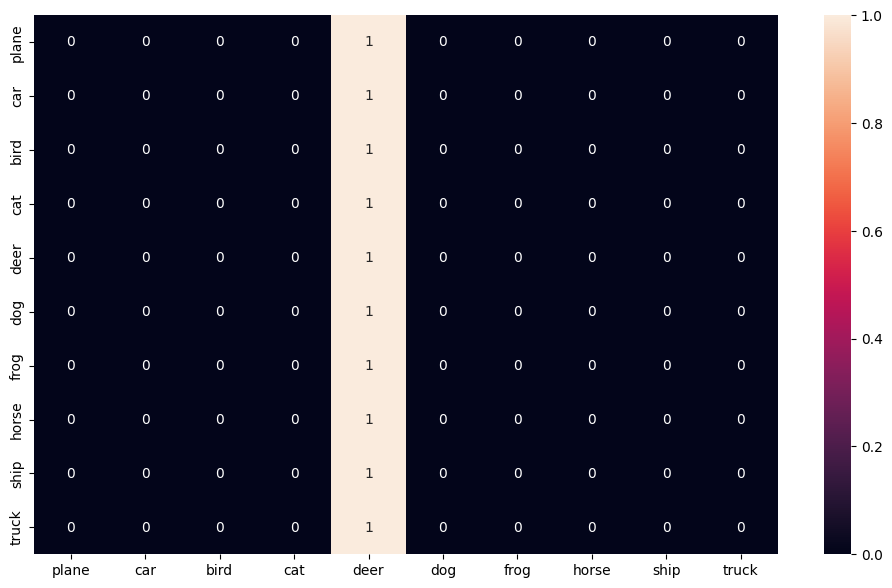

In [7]:
#track run, depth = 16
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"CNN depth 16",
    # Track hyperparameters and run metadata
    config={
    "initial_learning_rate": 0.001,
    "architecture": "CNN",
    "dataset": "Cifar10",
    "epochs": 100,
    "batch_size": 256,
    "validation_set_size": 5000,
    "layers": [3, 2, 2]})

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=run.config["batch_size"], shuffle=True)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size=run.config["batch_size"])
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=run.config["batch_size"], shuffle=False)

#Training and Test
device = 'cuda'

modelCNN = CNN(layers=run.config["layers"]).to(device)
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=run.config["initial_learning_rate"])
scheduler = MultiStepLR(optimizer, milestones=[80, 160], gamma=0.1)

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelCNN, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    validation_loss, validation_accuracy = evaluate(modelCNN, dl_val, run.config["validation_set_size"], classes)
    if validation_accuracy >= best_accuracy:
        state_dict = modelCNN.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    scheduler.step()

    wandb.log({**metrics, **val_metrics})

#Test
modelCNN.load_state_dict(state_dict)

#save model on weights and biases
model_artifact = wandb.Artifact(
    "CNN_16", type="model",
    description="best model for CNN with depth 16",
    metadata=dict(run.config))

torch.save(modelCNN.state_dict(), "best_model_cnn.pth")
model_artifact.add_file("best_model_cnn.pth")
wandb.save("best_model_cnn.pth")
run.log_artifact(model_artifact)

_, test_accuracy = evaluate(modelCNN, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

Runs with Residual connection

Training epoch 0: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Validation accuracy: 35.74%


Training epoch 1: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 42.5%


Training epoch 2: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 48.0%


Training epoch 3: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 53.72%


Training epoch 4: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 55.559999999999995%


Training epoch 5: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 58.64%


Training epoch 6: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 60.06%


Training epoch 7: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 61.24000000000001%


Training epoch 8: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Validation accuracy: 63.62%


Training epoch 9: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 64.42%


Training epoch 10: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Validation accuracy: 64.36%


Training epoch 11: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 67.12%


Training epoch 12: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 66.36%


Training epoch 13: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 67.56%


Training epoch 14: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Validation accuracy: 68.28%


Training epoch 15: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 68.97999999999999%


Training epoch 16: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 70.34%


Training epoch 17: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 69.58%


Training epoch 18: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 70.26%


Training epoch 19: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 71.26%


Training epoch 20: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 70.34%


Training epoch 21: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 70.76%


Training epoch 22: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Validation accuracy: 72.52%


Training epoch 23: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 72.74000000000001%


Training epoch 24: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 72.1%


Training epoch 25: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 72.42%


Training epoch 26: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 72.22%


Training epoch 27: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Validation accuracy: 72.98%


Training epoch 28: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 72.26%


Training epoch 29: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 73.5%


Training epoch 30: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 72.82%


Training epoch 31: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 73.06%


Training epoch 32: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.16%


Training epoch 33: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.0%


Training epoch 34: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 73.58%


Training epoch 35: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.11999999999999%


Training epoch 36: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 73.36%


Training epoch 37: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 73.46000000000001%


Training epoch 38: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.46000000000001%


Training epoch 39: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.11999999999999%


Training epoch 40: 100%|██████████| 176/176 [00:40<00:00,  4.35it/s]


Validation accuracy: 74.11999999999999%


Training epoch 41: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 73.82%


Training epoch 42: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 75.28%


Training epoch 43: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.98%


Training epoch 44: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.52%


Training epoch 45: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 73.66%


Training epoch 46: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Validation accuracy: 74.08%


Training epoch 47: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 75.22%


Training epoch 48: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.6%


Training epoch 49: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.36%


Training epoch 50: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 75.28%


Training epoch 51: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 75.02%


Training epoch 52: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 75.0%


Training epoch 53: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.6%


Training epoch 54: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 73.11999999999999%


Training epoch 55: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.92%


Training epoch 56: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 75.06%


Training epoch 57: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.78%


Training epoch 58: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 75.18%


Training epoch 59: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.56%


Training epoch 60: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 75.33999999999999%


Training epoch 61: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 75.3%


Training epoch 62: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.62%


Training epoch 63: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.26%


Training epoch 64: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 74.32%


Training epoch 65: 100%|██████████| 176/176 [00:40<00:00,  4.36it/s]


Validation accuracy: 75.4%


Training epoch 66: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Validation accuracy: 74.8%


Training epoch 67: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 75.1%


Training epoch 68: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.52%


Training epoch 69: 100%|██████████| 176/176 [00:40<00:00,  4.34it/s]


Validation accuracy: 74.76%


Training epoch 70: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.02%


Training epoch 71: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 76.32%


Training epoch 72: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.52%


Training epoch 73: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 75.98%


Training epoch 74: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.66000000000001%


Training epoch 75: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 75.84%


Training epoch 76: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.9%


Training epoch 77: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 75.4%


Training epoch 78: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 75.46000000000001%


Training epoch 79: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 74.4%


Training epoch 80: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 76.24%


Training epoch 81: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 76.28%


Training epoch 82: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 77.0%


Training epoch 83: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 76.94%


Training epoch 84: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 76.94%


Training epoch 85: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 77.28%


Training epoch 86: 100%|██████████| 176/176 [00:40<00:00,  4.32it/s]


Validation accuracy: 77.0%


Training epoch 87: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 77.32%


Training epoch 88: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 77.28%


Training epoch 89: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 77.42%


Training epoch 90: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 77.52%


Training epoch 91: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 77.46%


Training epoch 92: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 77.78%


Training epoch 93: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 76.96%


Training epoch 94: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 76.75999999999999%


Training epoch 95: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 77.86%


Training epoch 96: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 77.12%


Training epoch 97: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 77.16%


Training epoch 98: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 77.44%


Training epoch 99: 100%|██████████| 176/176 [00:40<00:00,  4.33it/s]


Validation accuracy: 77.18%
Accuracy report on TEST: 78.75%


Test Accuracy,▁
Train Loss,█▆▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇█▇██████▇██████████████
Validation Loss,█▆▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂
Test Accuracy,0.7875
Train Loss,0.20706
Validation Accuracy,0.7718
Validation Loss,0.86313


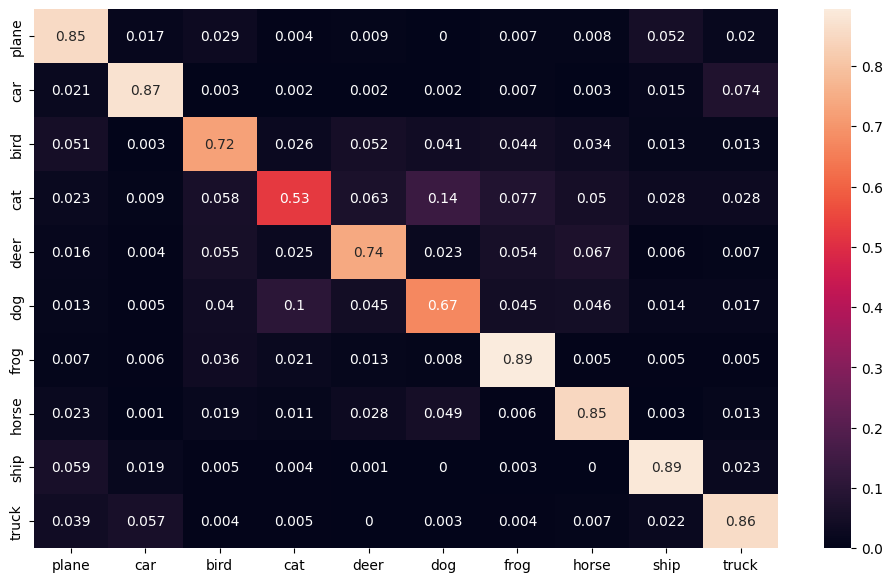

In [11]:
#track run, depth = 8
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"ResidualCNN depth 8",
    # Track hyperparameters and run metadata
    config={
    "initial_learning_rate": 0.001,
    "architecture": "ResidualCNN",
    "dataset": "Cifar10",
    "epochs": 100,
    "batch_size": 256,
    "validation_set_size": 5000,
    "layers": [1, 1, 1]})

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=run.config["batch_size"], shuffle=True)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size=run.config["batch_size"])
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=run.config["batch_size"], shuffle=False)

#Training and Test
device = 'cuda'

modelCNNR = CNN(layers=run.config["layers"], residual=True).to(device)
optimizer = torch.optim.Adam(modelCNNR.parameters(), lr=run.config["initial_learning_rate"])
scheduler = MultiStepLR(optimizer, milestones=[80, 160], gamma=0.1)

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelCNNR, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    validation_loss, validation_accuracy = evaluate(modelCNNR, dl_val, run.config["validation_set_size"], classes)
    if validation_accuracy >= best_accuracy:
        state_dict = modelCNNR.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    scheduler.step()

    wandb.log({**metrics, **val_metrics})

#Test
modelCNNR.load_state_dict(state_dict)

#save model on weights and biases
model_artifact = wandb.Artifact(
    "ResidualCNN_8", type="model",
    description="best model for ResidualCNN with depth 8",
    metadata=dict(run.config))

torch.save(modelCNNR.state_dict(), "best_model_rcnn.pth")
model_artifact.add_file("best_model_rcnn.pth")
wandb.save("best_model_rcnn.pth")
run.log_artifact(model_artifact)

_, test_accuracy = evaluate(modelCNNR, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

Training epoch 0: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 28.54%


Training epoch 1: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Validation accuracy: 41.02%


Training epoch 2: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Validation accuracy: 47.699999999999996%


Training epoch 3: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 51.28%


Training epoch 4: 100%|██████████| 176/176 [00:41<00:00,  4.25it/s]


Validation accuracy: 53.1%


Training epoch 5: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 57.92%


Training epoch 6: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 58.040000000000006%


Training epoch 7: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 61.06%


Training epoch 8: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 62.82%


Training epoch 9: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 63.839999999999996%


Training epoch 10: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 65.28%


Training epoch 11: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 67.24%


Training epoch 12: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 67.47999999999999%


Training epoch 13: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 68.74%


Training epoch 14: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 68.82000000000001%


Training epoch 15: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 68.76%


Training epoch 16: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 69.34%


Training epoch 17: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 71.32%


Training epoch 18: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Validation accuracy: 70.92%


Training epoch 19: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 70.96000000000001%


Training epoch 20: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 70.74000000000001%


Training epoch 21: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 71.16%


Training epoch 22: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 71.7%


Training epoch 23: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 71.17999999999999%


Training epoch 24: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 72.44%


Training epoch 25: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 72.34%


Training epoch 26: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 72.22%


Training epoch 27: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Validation accuracy: 73.6%


Training epoch 28: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 72.86%


Training epoch 29: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 73.22%


Training epoch 30: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 73.42%


Training epoch 31: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 72.92%


Training epoch 32: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 74.2%


Training epoch 33: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 73.54%


Training epoch 34: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 73.58%


Training epoch 35: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 73.88%


Training epoch 36: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 73.4%


Training epoch 37: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.68%


Training epoch 38: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.48%


Training epoch 39: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 73.64%


Training epoch 40: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.62%


Training epoch 41: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.24%


Training epoch 42: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.02%


Training epoch 43: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.4%


Training epoch 44: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.78%


Training epoch 45: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.68%


Training epoch 46: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 75.38%


Training epoch 47: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.46000000000001%


Training epoch 48: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.76%


Training epoch 49: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.2%


Training epoch 50: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.1%


Training epoch 51: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 75.8%


Training epoch 52: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 75.3%


Training epoch 53: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 75.82%


Training epoch 54: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 75.3%


Training epoch 55: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 75.14%


Training epoch 56: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 75.36%


Training epoch 57: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 74.83999999999999%


Training epoch 58: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 76.75999999999999%


Training epoch 59: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 74.1%


Training epoch 60: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 75.14%


Training epoch 61: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 75.74%


Training epoch 62: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 75.06%


Training epoch 63: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 75.32%


Training epoch 64: 100%|██████████| 176/176 [00:42<00:00,  4.16it/s]


Validation accuracy: 74.88%


Training epoch 65: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 76.03999999999999%


Training epoch 66: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 75.62%


Training epoch 67: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 76.22%


Training epoch 68: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 74.4%


Training epoch 69: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 75.12%


Training epoch 70: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 75.0%


Training epoch 71: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Validation accuracy: 76.5%


Training epoch 72: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 75.74%


Training epoch 73: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 75.28%


Training epoch 74: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.78%


Training epoch 75: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 76.22%


Training epoch 76: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.42%


Training epoch 77: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 75.22%


Training epoch 78: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 75.96000000000001%


Training epoch 79: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 75.36%


Training epoch 80: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 77.62%


Training epoch 81: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 77.66%


Training epoch 82: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 76.82%


Training epoch 83: 100%|██████████| 176/176 [00:42<00:00,  4.17it/s]


Validation accuracy: 78.12%


Training epoch 84: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 77.84%


Training epoch 85: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 77.8%


Training epoch 86: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 78.2%


Training epoch 87: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 77.94%


Training epoch 88: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 77.8%


Training epoch 89: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 77.52%


Training epoch 90: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 78.06%


Training epoch 91: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 78.18%


Training epoch 92: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 77.78%


Training epoch 93: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 78.32000000000001%


Training epoch 94: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 77.84%


Training epoch 95: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 78.08%


Training epoch 96: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 78.25999999999999%


Training epoch 97: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 78.53999999999999%


Training epoch 98: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 77.82%


Training epoch 99: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 78.86%
Accuracy report on TEST: 79.06%


Test Accuracy,▁
Train Loss,█▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Validation Accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇██▇██▇█████████
Validation Loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Accuracy,0.7906
Train Loss,0.2496
Validation Accuracy,0.7886
Validation Loss,0.73329


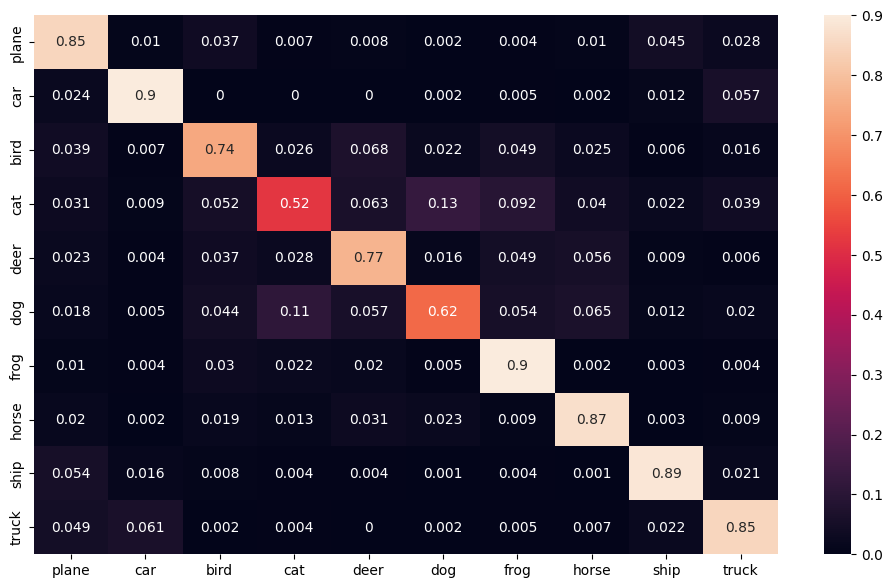

In [12]:
#track run, depth = 14
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"ResidualCNN depth 14",
    # Track hyperparameters and run metadata
    config={
    "initial_learning_rate": 0.001,
    "architecture": "ResidualCNN",
    "dataset": "Cifar10",
    "epochs": 100,
    "batch_size": 256,
    "validation_set_size": 5000,
    "layers": [2, 2, 2]})

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=run.config["batch_size"], shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=run.config["batch_size"])
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=run.config["batch_size"], shuffle=False)

#Training and Test
device = 'cuda'

modelCNNR = CNN(layers=run.config["layers"], residual=True).to(device)
optimizer = torch.optim.Adam(modelCNNR.parameters(), lr=run.config["initial_learning_rate"])
scheduler = MultiStepLR(optimizer, milestones=[80, 160], gamma=0.1)

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelCNNR, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    validation_loss, validation_accuracy = evaluate(modelCNNR, dl_val, run.config["validation_set_size"], classes)
    if validation_accuracy >= best_accuracy:
        state_dict = modelCNNR.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    scheduler.step()

    wandb.log({**metrics, **val_metrics})

#Test
modelCNNR.load_state_dict(state_dict)

#save model on weights and biases
model_artifact = wandb.Artifact(
    "ResidualCNN_14", type="model",
    description="best model for ResidualCNN with depth 14",
    metadata=dict(run.config))

torch.save(modelCNNR.state_dict(), "best_model_rcnn.pth")
model_artifact.add_file("best_model_rcnn.pth")
wandb.save("best_model_rcnn.pth")
run.log_artifact(model_artifact)

_, test_accuracy = evaluate(modelCNNR, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

Training epoch 0: 100%|██████████| 176/176 [00:42<00:00,  4.10it/s]


Validation accuracy: 33.1%


Training epoch 1: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 42.92%


Training epoch 2: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 48.6%


Training epoch 3: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 51.32%


Training epoch 4: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 55.84%


Training epoch 5: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 58.699999999999996%


Training epoch 6: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 58.919999999999995%


Training epoch 7: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 59.84%


Training epoch 8: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 63.660000000000004%


Training epoch 9: 100%|██████████| 176/176 [00:41<00:00,  4.19it/s]


Validation accuracy: 64.28%


Training epoch 10: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 64.7%


Training epoch 11: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 67.56%


Training epoch 12: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 67.30000000000001%


Training epoch 13: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 66.97999999999999%


Training epoch 14: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 68.46%


Training epoch 15: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 68.28%


Training epoch 16: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 70.02000000000001%


Training epoch 17: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 69.96%


Training epoch 18: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 69.78%


Training epoch 19: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 71.2%


Training epoch 20: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 70.04%


Training epoch 21: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 69.76%


Training epoch 22: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 71.0%


Training epoch 23: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 71.5%


Training epoch 24: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 71.67999999999999%


Training epoch 25: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 70.89999999999999%


Training epoch 26: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 72.5%


Training epoch 27: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 72.54%


Training epoch 28: 100%|██████████| 176/176 [00:42<00:00,  4.16it/s]


Validation accuracy: 71.88%


Training epoch 29: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 73.34%


Training epoch 30: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 72.84%


Training epoch 31: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 73.4%


Training epoch 32: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 73.88%


Training epoch 33: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.36%


Training epoch 34: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 74.06%


Training epoch 35: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 72.89999999999999%


Training epoch 36: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 73.9%


Training epoch 37: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.08%


Training epoch 38: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 74.1%


Training epoch 39: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 74.6%


Training epoch 40: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 74.64%


Training epoch 41: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 74.56%


Training epoch 42: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 73.88%


Training epoch 43: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 73.14%


Training epoch 44: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 74.11999999999999%


Training epoch 45: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 74.62%


Training epoch 46: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 74.76%


Training epoch 47: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 74.3%


Training epoch 48: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 73.83999999999999%


Training epoch 49: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 74.7%


Training epoch 50: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 73.94%


Training epoch 51: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 75.48%


Training epoch 52: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 75.64%


Training epoch 53: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 74.28%


Training epoch 54: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 74.66000000000001%


Training epoch 55: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 74.78%


Training epoch 56: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 74.28%


Training epoch 57: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 73.78%


Training epoch 58: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 74.88%


Training epoch 59: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 74.16%


Training epoch 60: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 75.42%


Training epoch 61: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 75.03999999999999%


Training epoch 62: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 75.02%


Training epoch 63: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 74.7%


Training epoch 64: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.38%


Training epoch 65: 100%|██████████| 176/176 [00:42<00:00,  4.19it/s]


Validation accuracy: 75.26%


Training epoch 66: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 75.22%


Training epoch 67: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 75.74%


Training epoch 68: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 73.82%


Training epoch 69: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 73.38%


Training epoch 70: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 75.58%


Training epoch 71: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.88%


Training epoch 72: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 75.33999999999999%


Training epoch 73: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 74.44%


Training epoch 74: 100%|██████████| 176/176 [00:42<00:00,  4.18it/s]


Validation accuracy: 75.38%


Training epoch 75: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 74.14%


Training epoch 76: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 74.66000000000001%


Training epoch 77: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 75.22%


Training epoch 78: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 75.1%


Training epoch 79: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 74.62%


Training epoch 80: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 76.4%


Training epoch 81: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 76.44%


Training epoch 82: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 77.22%


Training epoch 83: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 76.68%


Training epoch 84: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 77.56%


Training epoch 85: 100%|██████████| 176/176 [00:41<00:00,  4.20it/s]


Validation accuracy: 77.08%


Training epoch 86: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 78.12%


Training epoch 87: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 77.53999999999999%


Training epoch 88: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 77.22%


Training epoch 89: 100%|██████████| 176/176 [00:41<00:00,  4.24it/s]


Validation accuracy: 77.75999999999999%


Training epoch 90: 100%|██████████| 176/176 [00:41<00:00,  4.23it/s]


Validation accuracy: 77.14%


Training epoch 91: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 77.10000000000001%


Training epoch 92: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 77.16%


Training epoch 93: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 77.58%


Training epoch 94: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 77.02%


Training epoch 95: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 77.03999999999999%


Training epoch 96: 100%|██████████| 176/176 [00:41<00:00,  4.22it/s]


Validation accuracy: 77.9%


Training epoch 97: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 76.98%


Training epoch 98: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 77.3%


Training epoch 99: 100%|██████████| 176/176 [00:41<00:00,  4.21it/s]


Validation accuracy: 77.66%
Accuracy report on TEST: 78.47%


Test Accuracy,▁
Train Loss,█▆▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Validation Accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇█████████
Validation Loss,█▆▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▂▁▁▁▁▁▁▂▂▁
Test Accuracy,0.7847
Train Loss,0.23986
Validation Accuracy,0.7766
Validation Loss,0.81627


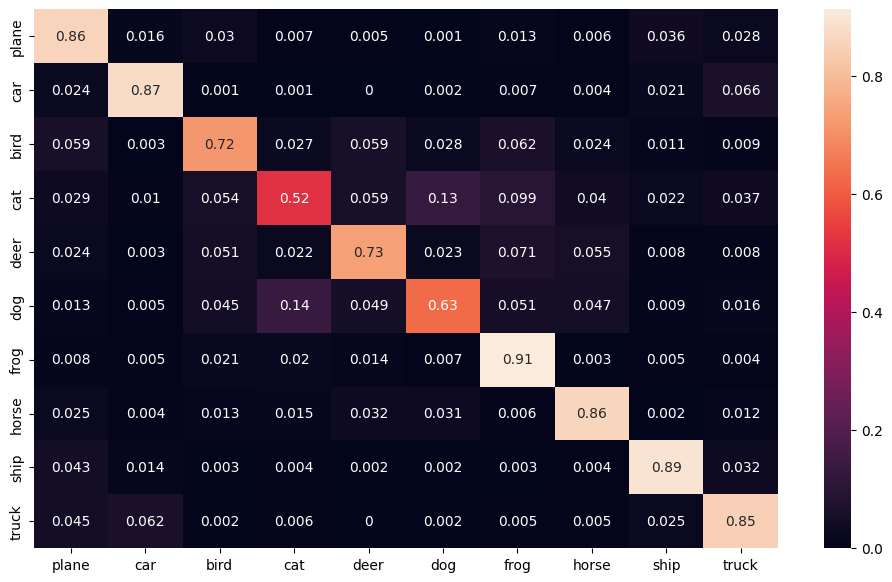

In [8]:
#track run, depth = 20
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"ResidualCNN depth 20",
    # Track hyperparameters and run metadata
    config={
    "initial_learning_rate": 0.001,
    "architecture": "ResidualCNN",
    "dataset": "Cifar10",
    "epochs": 100,
    "batch_size": 256,
    "validation_set_size": 5000,
    "layers": [3, 4, 2]})

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=run.config["batch_size"], shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=run.config["batch_size"])
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=run.config["batch_size"], shuffle=False)

#Training and Test
device = 'cuda'

modelCNNR = CNN(layers=run.config["layers"], residual=True).to(device)
optimizer = torch.optim.Adam(modelCNNR.parameters(), lr=run.config["initial_learning_rate"])
scheduler = MultiStepLR(optimizer, milestones=[80, 160], gamma=0.1)

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelCNNR, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    validation_loss, validation_accuracy = evaluate(modelCNNR, dl_val, run.config["validation_set_size"], classes)
    if validation_accuracy >= best_accuracy:
        state_dict = modelCNNR.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    scheduler.step()

    wandb.log({**metrics, **val_metrics})

#Test
modelCNNR.load_state_dict(state_dict)

#save model on weights and biases
model_artifact = wandb.Artifact(
    "ResidualCNN_20", type="model",
    description="best model for ResidualCNN with depth 20",
    metadata=dict(run.config))

torch.save(modelCNNR.state_dict(), "best_model_rcnn.pth")
model_artifact.add_file("best_model_rcnn.pth")
wandb.save("best_model_rcnn.pth")
run.log_artifact(model_artifact)

_, test_accuracy = evaluate(modelCNNR, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

**Note**: Feel free to implement [Grad-CAM](https://arxiv.org/abs/1610.02391) instead of CAM.

In [6]:
#GradCam implementation
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL
import torch.nn.functional as F
import matplotlib.pyplot as plt

transform_norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
# Defines two global scope variables to store gradients and activations
gradients = None
activations = None

# The hook is called every time the gradients with respect to a module are computed
def backward_hook(module, grad_input, grad_output):
    global gradients
    print('Backward hook running...')
    gradients = grad_output

# The hook is called every time after forward() has computed an output 
def forward_hook(module, args, output):
    global activations # refers to the variable in the global scope
    print('Forward hook running...')
    activations = output

def gradCAM(model, iter_dl_test, image_size=32):
    # Get the images
    data  = next(iter_dl_test)
    image_show, target = data
    # Normalize the image that is fed to the CNN
    image = transform_norm(image_show)
    image, target, image_show = image.to(device), target.to(device), image_show.to(device)

    # Calculate the loss and backprogate to accumulate gradients and activations
    model.eval()
    logits = model(image)
    loss = F.cross_entropy(logits, target)
    _, predicted = torch.max(logits.data, 1)
    loss.backward()

    # Gradients are global-average-pooled over the width and height dimensions
    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

    # Weighed combination of activations using the pooled gradients as weights
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # Relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # Normalize the heatmap (if the max is not zero)
    if torch.max(heatmap) != 0:
        heatmap /= torch.max(heatmap)

    # draw the heatmap
    print(f"Heatmap:")
    plt.figure(figsize=(3.5,3.5))
    plt.matshow(heatmap.detach().cpu(), fignum=1)

    plt.figure(figsize=(8,8))

    # Plot the original rgb image and its ground truth
    ax = plt.subplot(1,2,1)
    ax.axis('off') # removes the axis markers
    ax.set_title(f"Label: {str(classes[target.item()])} ")
    plt.imshow(to_pil_image(image_show.squeeze(), mode='RGB'))

    # First plot the original image
    ax = plt.subplot(1,2,2)
    ax.axis('off') # removes the axis markers
    ax.set_title(f"Predicted: {str(classes[predicted])} ")
    ax.imshow(to_pil_image(image_show.squeeze(), mode='RGB'))

    # Resize the heatmap to the same size as the input image and defines
    # a resample algorithm for increasing image resolution
    # we need heatmap.detach() because it can't be converted to numpy array while
    # requiring gradients
    overlay = to_pil_image(heatmap.detach(), mode='F').resize((image_size,image_size), resample=PIL.Image.BICUBIC)

    # Apply any colormap you want
    cmap = colormaps['jet']
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

    # Plot the heatmap on the same axes, 
    # but with alpha < 1 (this defines the transparency of the heatmap)
    ax.imshow(overlay, alpha=0.4, interpolation='nearest')  #capisci extend

    # Show the plot
    plt.show()

wandb:   1 of 1 files downloaded.  


Files already downloaded and verified


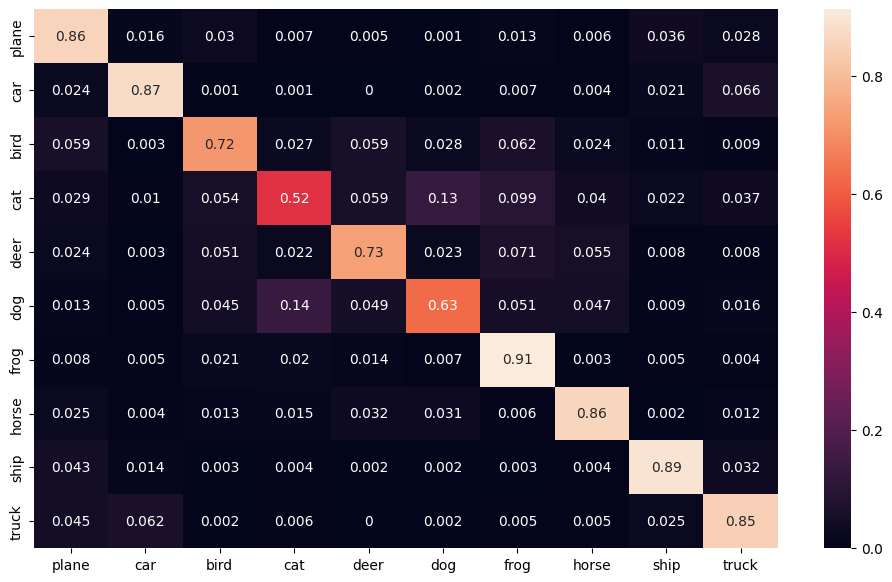

In [7]:
device = 'cuda'

# Get trained model from wandb
model_rcnn = CNN(layers = [3,4,2], num_classes = 10, residual = True).to(device)

run = wandb.init()

artifact = run.use_artifact('dla-labs/Lab1-Submission/ResidualCNN_20:v0', type='model')
artifact_dir = artifact.download()

run.finish()

transform = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
# Load CIFAR10 test.
cifar10_test_acc = CIFAR10(root='./data', train=False, download=True, transform=transform)
# Dataloader
dl_test_cifar_acc = torch.utils.data.DataLoader(cifar10_test_acc, 256, shuffle=True)

model_rcnn.load_state_dict(torch.load(artifact_dir+'/best_model_rcnn.pth'))

test_accuracy = evaluate(model_rcnn, dl_test_cifar_acc, 5000, classes = classes, device = device, test = True)

Files already downloaded and verified


Forward hook running...
Backward hook running...
Heatmap:


/data01/dl24nicara/DLA/.venv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


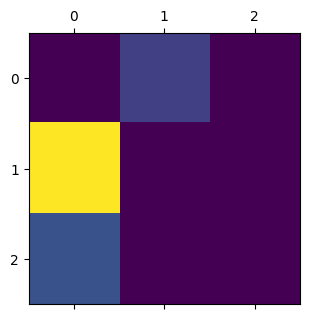

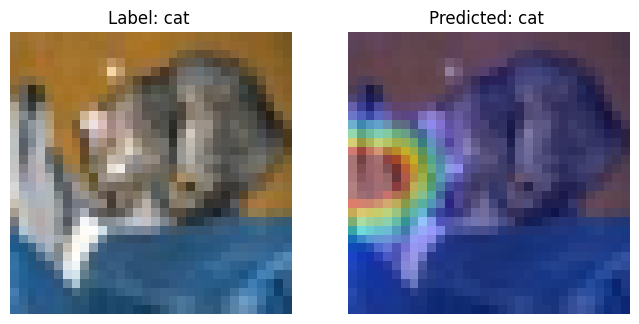

Forward hook running...
Backward hook running...
Heatmap:


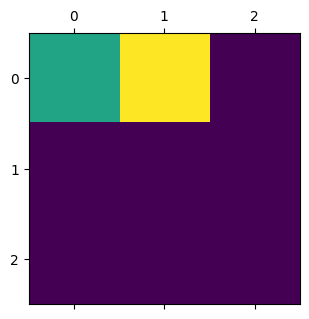

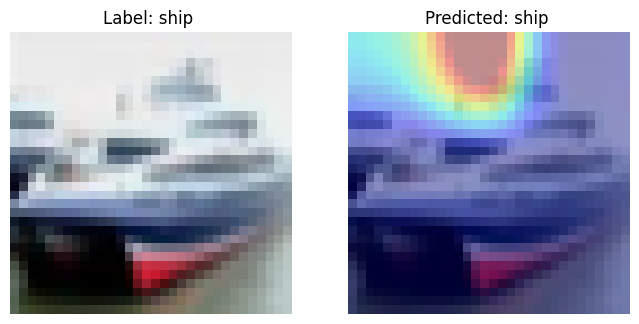

Forward hook running...
Backward hook running...
Heatmap:


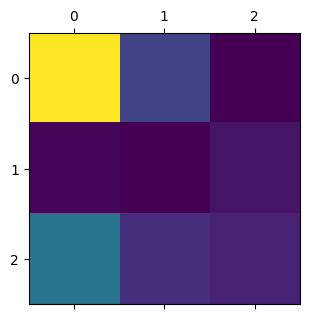

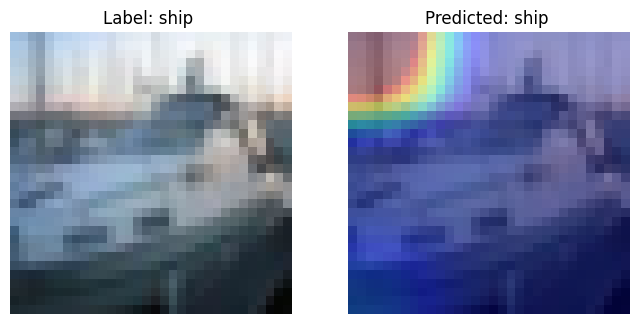

Forward hook running...
Backward hook running...
Heatmap:


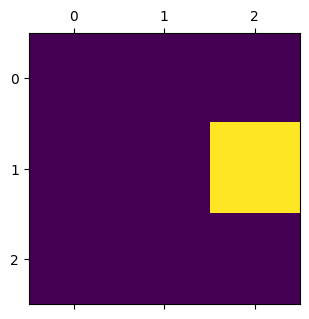

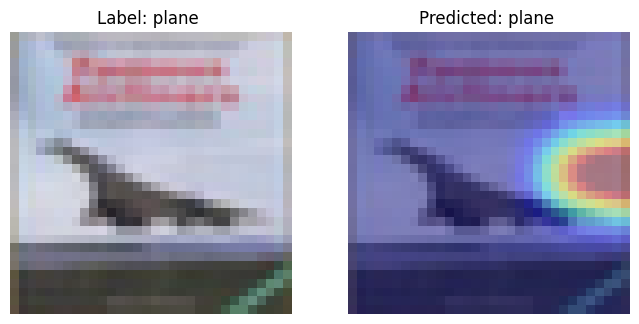

Forward hook running...
Backward hook running...
Heatmap:


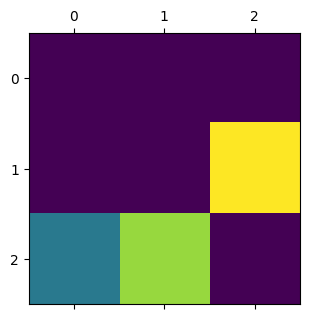

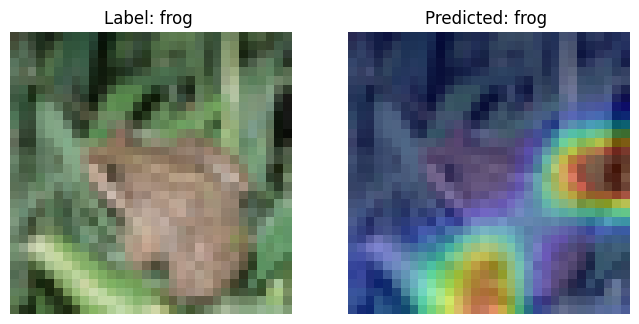

Forward hook running...
Backward hook running...
Heatmap:


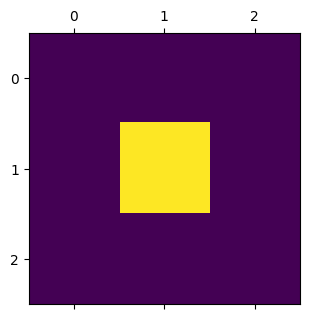

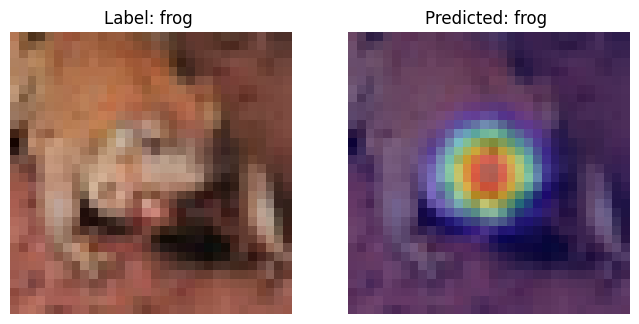

Forward hook running...
Backward hook running...
Heatmap:


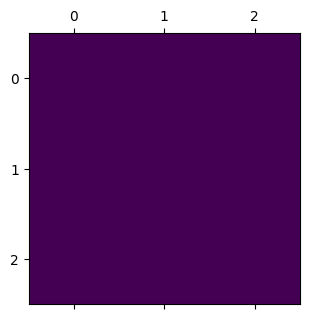

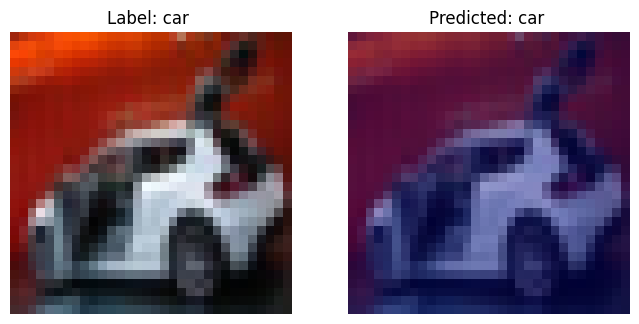

Forward hook running...
Backward hook running...
Heatmap:


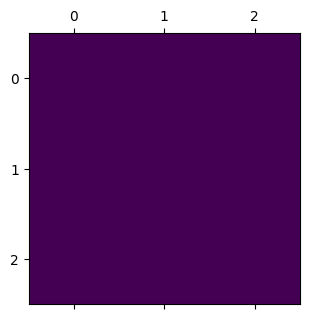

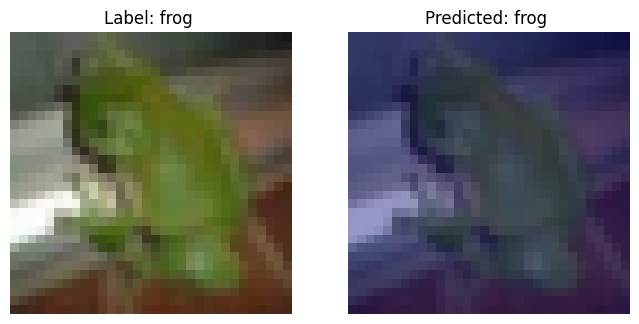

Forward hook running...
Backward hook running...
Heatmap:


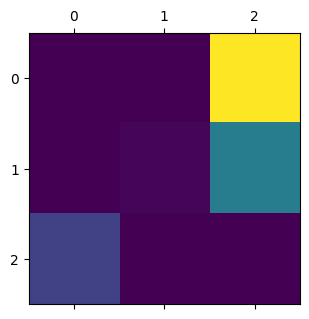

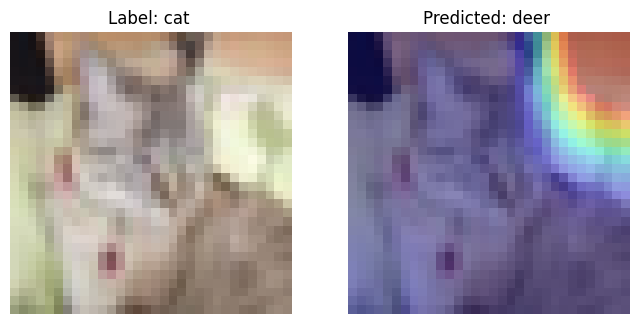

Forward hook running...
Backward hook running...
Heatmap:


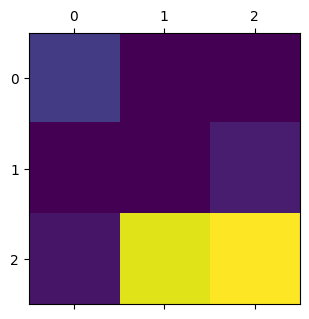

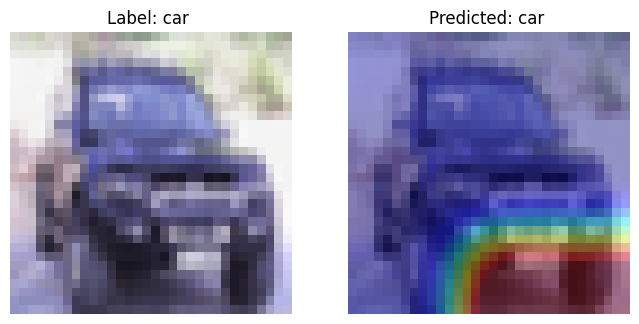

In [8]:
#Layer 3 prediction
# Register a backward hook on the module 
backward_hook_rCNN_3 = model_rcnn.layer3[-1].register_full_backward_hook(backward_hook, prepend=False)
# Register a forward hook on the module
forward_hook_rCNN_3 = model_rcnn.layer3[-1].register_forward_hook(forward_hook, prepend=False)

# Choosing a seed to get always the same images
torch.manual_seed(22)

#DataLoader with a single image per batch
ds_test = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor()) #without normalization
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=1, shuffle=False)
iter_dl_test = iter(dl_test)

for _ in range(10):
    gradCAM(model_rcnn, iter_dl_test)

Forward hook running...
Backward hook running...
Heatmap:


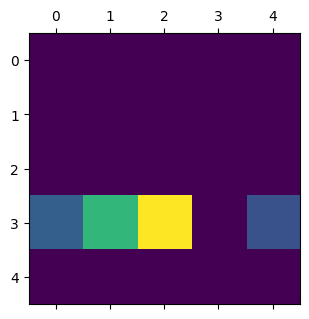

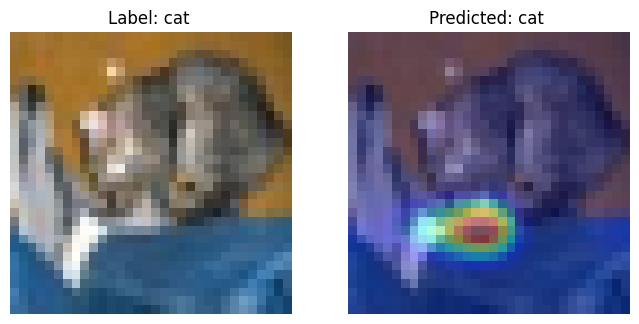

Forward hook running...
Backward hook running...
Heatmap:


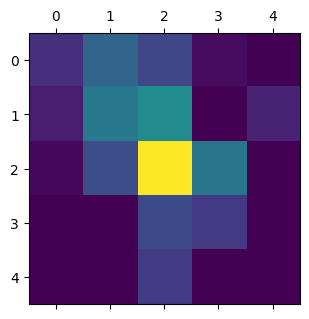

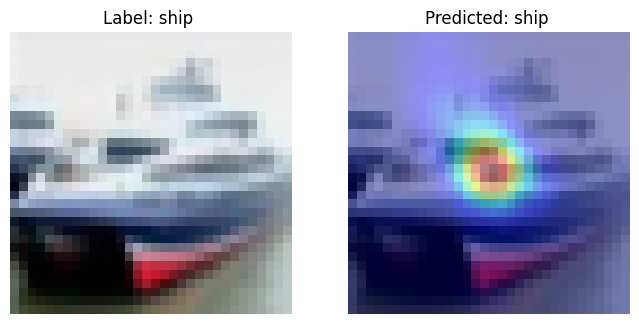

Forward hook running...
Backward hook running...
Heatmap:


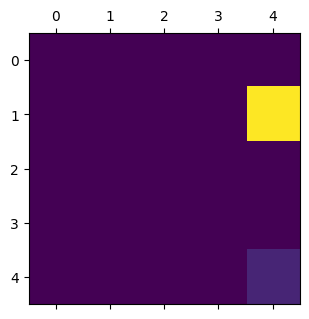

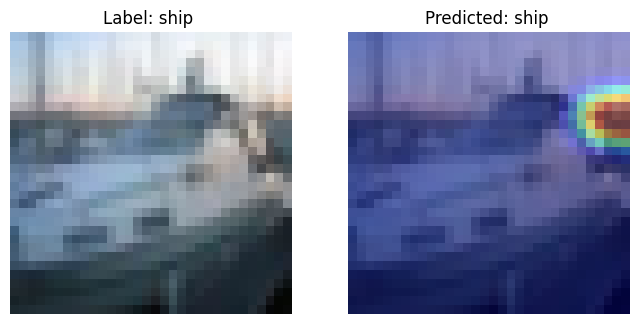

Forward hook running...
Backward hook running...
Heatmap:


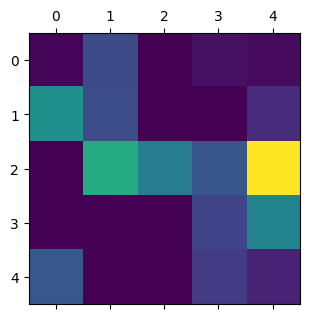

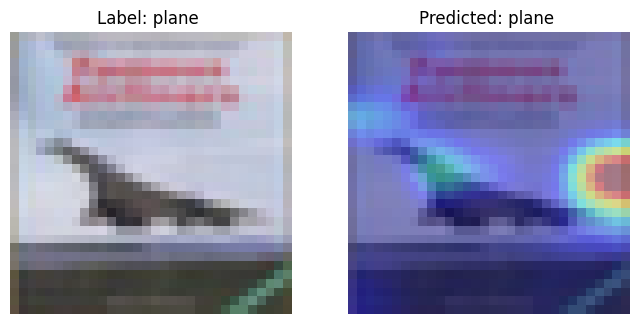

Forward hook running...
Backward hook running...
Heatmap:


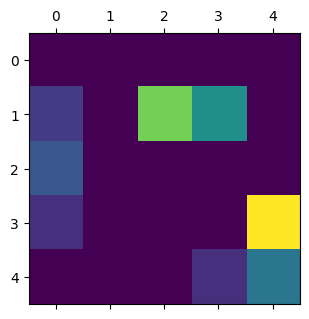

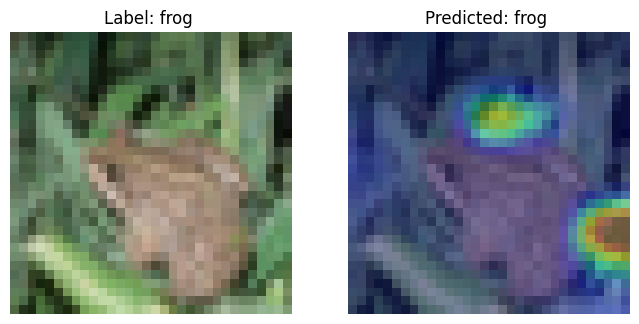

Forward hook running...
Backward hook running...
Heatmap:


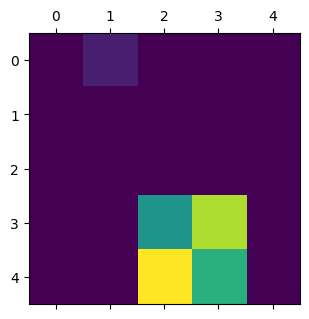

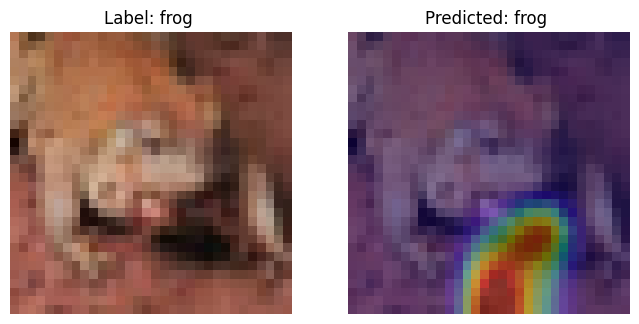

Forward hook running...
Backward hook running...
Heatmap:


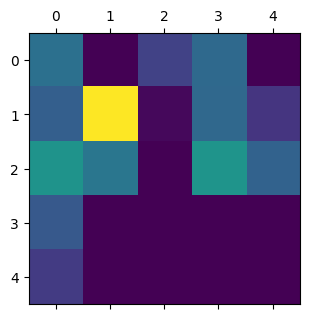

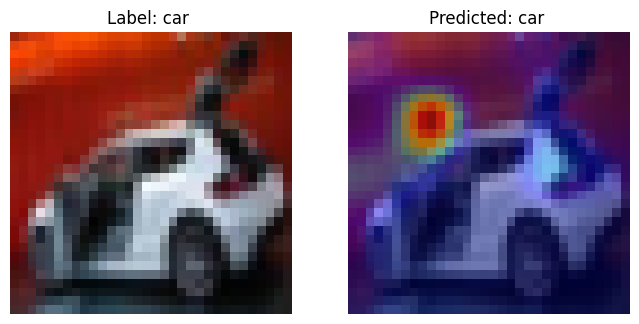

Forward hook running...
Backward hook running...
Heatmap:


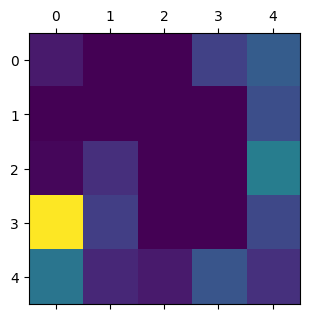

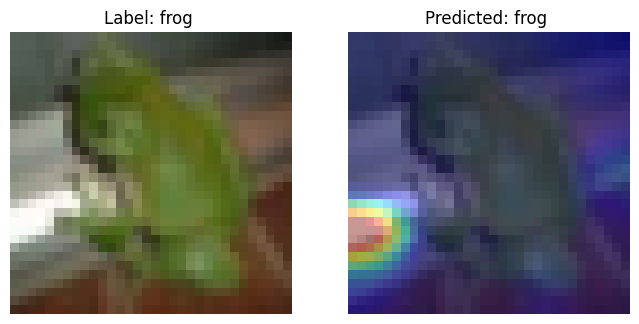

Forward hook running...
Backward hook running...
Heatmap:


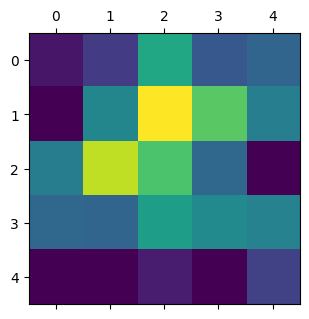

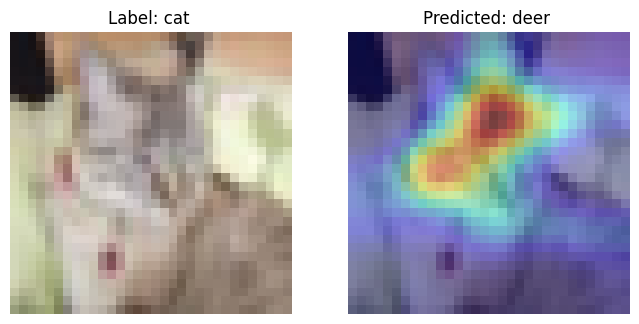

Forward hook running...
Backward hook running...
Heatmap:


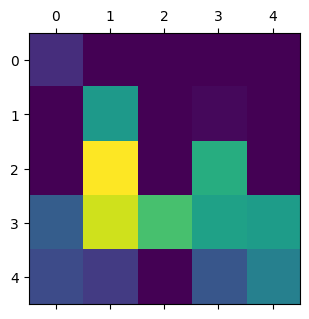

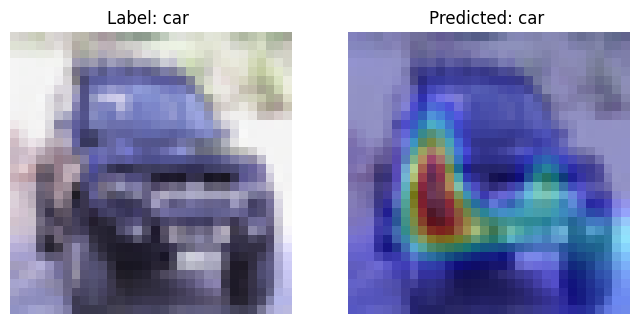

In [9]:
backward_hook_rCNN_3.remove()
forward_hook_rCNN_3.remove()

#Layer 2 Prediction
# Register a backward hook on the module 
backward_hook_rCNN_2 = model_rcnn.layer2[-1].register_full_backward_hook(backward_hook, prepend=False)
# Register a forward hook on the module
forward_hook_rCNN_2 = model_rcnn.layer2[-1].register_forward_hook(forward_hook, prepend=False)

# Choosing a seed to get always the same images
torch.manual_seed(22)
iter_dl_test = iter(dl_test)

for _ in range(10):
    gradCAM(model_rcnn, iter_dl_test)

Forward hook running...
Backward hook running...
Heatmap:


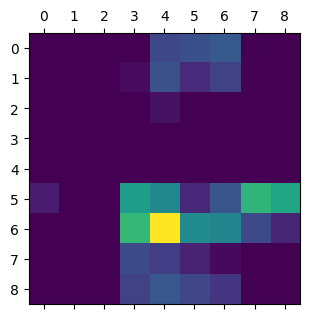

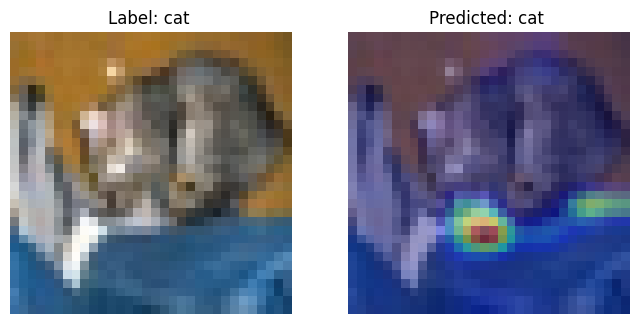

Forward hook running...
Backward hook running...
Heatmap:


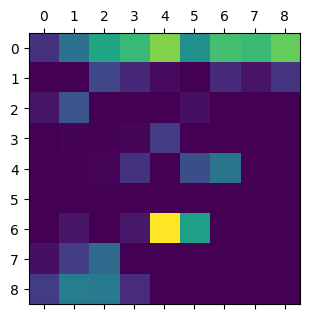

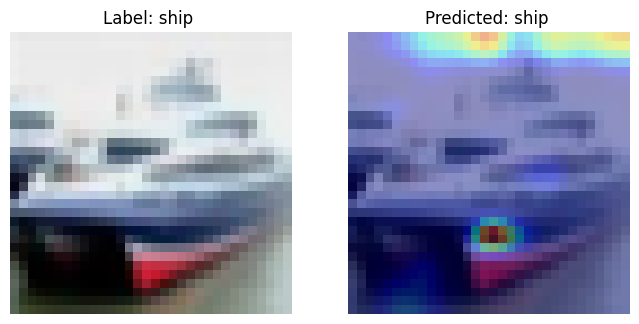

Forward hook running...
Backward hook running...
Heatmap:


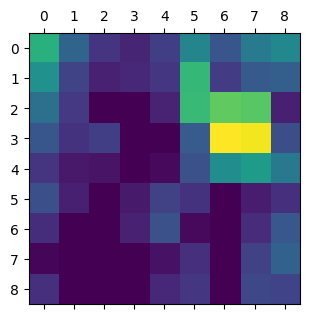

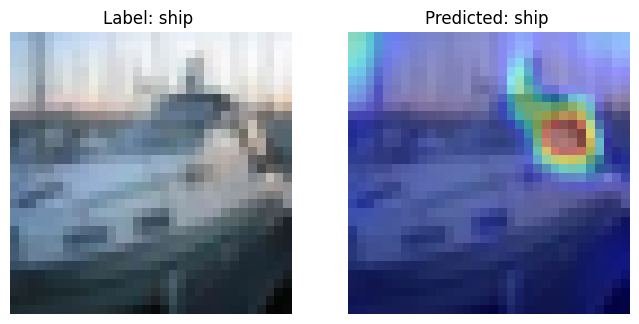

Forward hook running...
Backward hook running...
Heatmap:


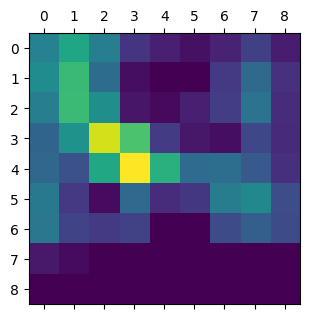

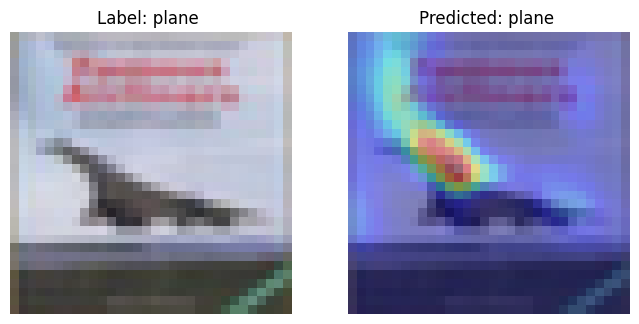

Forward hook running...
Backward hook running...
Heatmap:


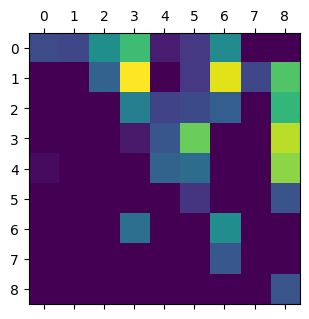

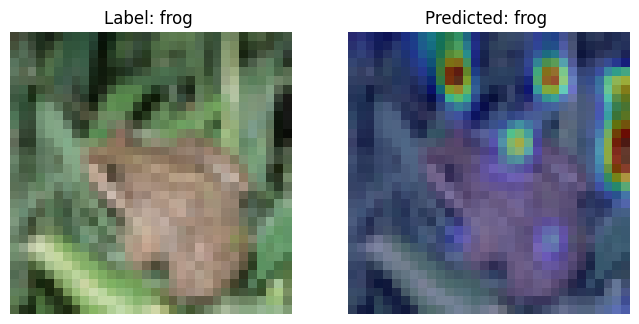

Forward hook running...
Backward hook running...
Heatmap:


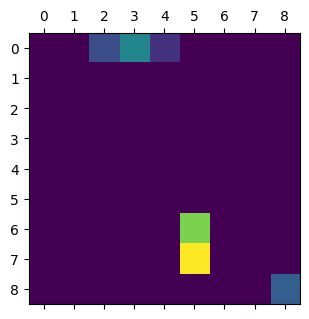

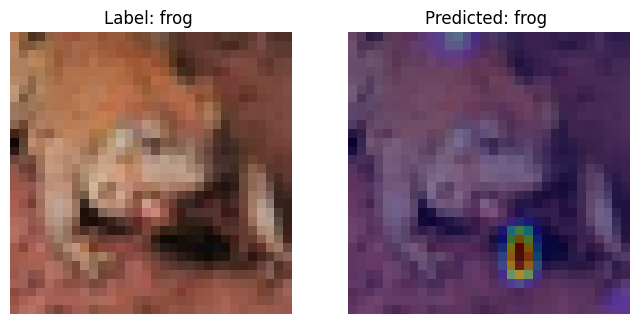

Forward hook running...
Backward hook running...
Heatmap:


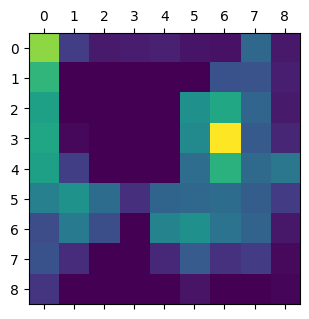

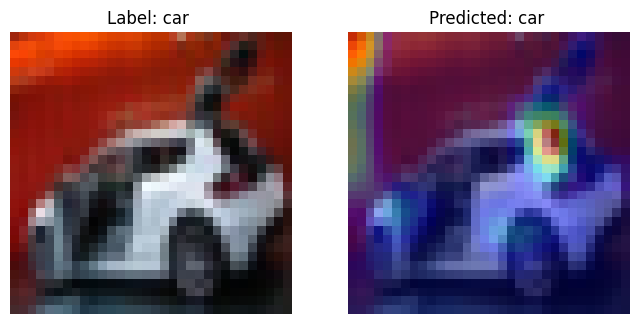

Forward hook running...
Backward hook running...
Heatmap:


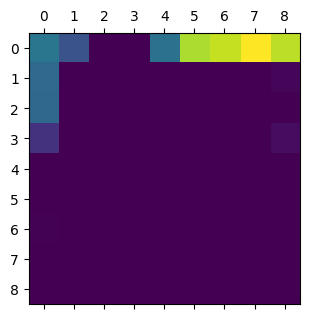

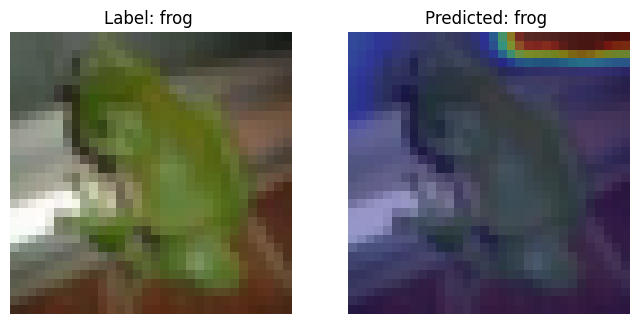

Forward hook running...
Backward hook running...
Heatmap:


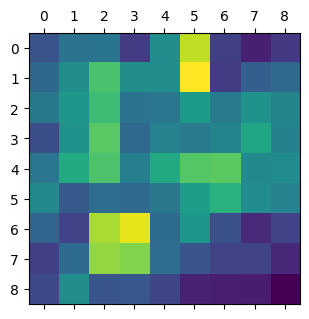

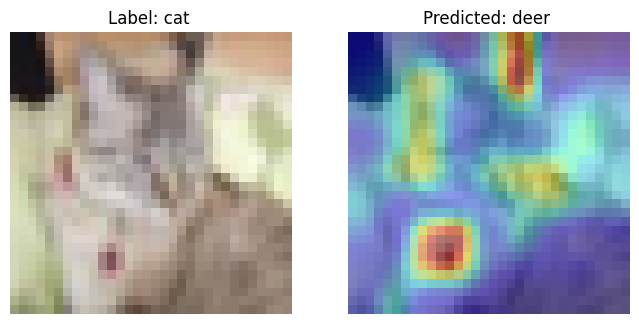

Forward hook running...
Backward hook running...
Heatmap:


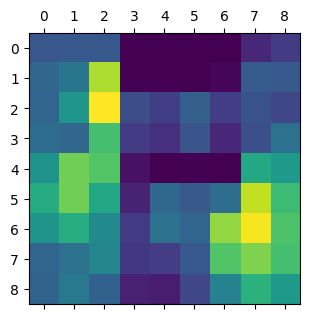

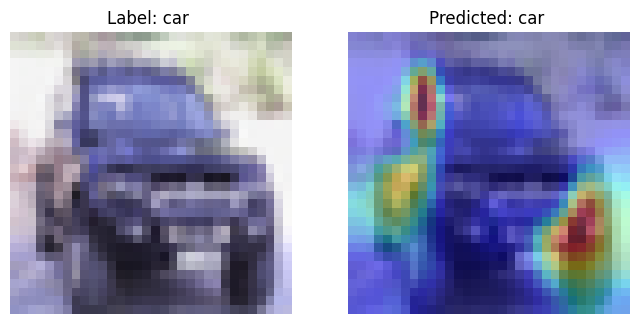

In [10]:
backward_hook_rCNN_2.remove()
forward_hook_rCNN_2.remove()

#Layer 1 Prediction
# Register a backward hook on the module 
backward_hook_CNN_1 = model_rcnn.layer1[-1].register_full_backward_hook(backward_hook, prepend=False)
# Register a forward hook on the module
forward_hook_CNN_1 = model_rcnn.layer1[-1].register_forward_hook(forward_hook, prepend=False)

# Choosing a seed to get always the same images
torch.manual_seed(22)
iter_dl_test = iter(dl_test)

for _ in range(10):
    gradCAM(model_rcnn, iter_dl_test)